<a href="https://colab.research.google.com/github/tinasandu/Teacher-Analysis-Pipelines/blob/main/Fusion_Training_and_Overall_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation

This is a notebook used to evaluate the models created in Models.ipynb and the data distribution for single and multi modal predictions.

# Imports

In [ ]:
from google.colab import drive
from pathlib import Path
import math
import os
import cv2
from google.colab.patches import cv2_imshow
from os.path import exists, join, basename, splitext
import numpy as np

# Import general libraries
import sys
import warnings
from scipy.io.wavfile import read
import torch.nn.functional as F
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv
import random
from collections import defaultdict

# Audio

#  https://github.com/tyiannak/pyAudioAnalysis/tree/master/pyAudioAnalysis 

!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub

import eyed3
import pydub
from pyAudioAnalysis import audioTrainTest as aT
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import librosa

!pip install shapely
from shapely.geometry import Polygon

#torch
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

### VA for face
!pip install timm==0.4.5
from PIL import Image

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

%load_ext google.colab.data_table
content_path = '/content/drive/MyDrive/thesis_pipeline'
data_path = './data/'
drive.mount('/content/drive/') # Outputs will be saved in your google drive

content_path = Path(content_path)

if not os.path.exists(content_path/'frames/'):
    os.makedirs(content_path/'frames/')

if not os.path.exists(content_path/'videos/'):
    os.makedirs(content_path/'videos/')    

## Use Videos from app
features = ["POSE", "FACIAL EXPRESSION", "VOICE", "OVERALL PERFORMANCE"] 

# Content from the below two variables has been removed to protect the intellectual 
# property of Imperial College London
links = {}
links2= {}

# use gpu if available
USE_GPU = True
dtype = torch.float32 

# Function for grouping list items 
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    args = [iter(iterable)] * n
    return list(zip_longest(*args, fillvalue=fillvalue))

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

# Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# set the seed for reproducibility
rng_seed = 90

torch.manual_seed(rng_seed)

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
cuda:0


In [ ]:
## The following lines are used to load the API files so that their content can be used to train and evaluate the models.
# They must be re-run if any of the API files are changed

execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')
execfile(f'{content_path}/API/regression.py')
execfile(f'{content_path}/API/fusion.py')

# Data category size experiments

Here we use the data sets we have created to print the number of frames that are associated with scores in various score groups.

  The first cell is used to obtain group sizes for face and pose, the second is used for voice and the third for overall scores.

In [ ]:
# Batch 1
# video_labels=f'{content_path}/video_features/opinions_visual.csv'
# video_path=f'{content_path}/video_features/video_b1_'

# Batch 2
video_labels=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

# VA and Align must be False, augment and tranform must be True and frames_per_seq must be 1
# Change the first arg between face and pose to see the breakdown for the two modalities.
_ =  VisualFeatureDatasetLSTMfromDF("face", "train_6", video_path, video_labels, 
                                               VA=False, augment=True, transform = True, 
                                               align=False, frames_per_seq= 1, 
                                               device=device)


load from dataframe - raw frames
torch.Size([10836])
torch.Size([10836])
torch.Size([10836, 1, 70, 3])
good 228
n_good 6722
n_bad 3887
bad 0

here - number of sequences for face
torch.Size([15408, 1, 1, 70, 3])
torch.Size([15408])


In [ ]:
# Batch 1
# audio_labels = f"{content_path}/dataset/audio/opinions_audio.csv"
# audio_path = f"{content_path}/dataset/audio/"

# # Batch 2
audio_labels=f'{content_path}/test_pipeline/opinions_audio.csv'
audio_path=f'{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments'

_ = VocalSnippetsDatasetfromDF(audio_labels, audio_path, "train_6", transform=False, VA=False, count_groups=True)

1215

here - number of audio sequences
1204
good 246
n_good 515
n_bad 421
bad 28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:748: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
_ = MultiModalDataset("train_6", audio_path, audio_labels,
                                 video_path, video_labels,
                                 frames_per_seq=1, device=device, count_groups=True)


good 396
n_good 8235
n_bad 2200
bad 6


# Pose

Here we obtain the results for the POSE and gestures feature for each batch, using multiple tests. Passing the second argument in the VisualFeatureDatasetLSTMfromDF generates a partition of the dataset

## Batch 1

In [ ]:
# Set batch 1 data paths
path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'

seq_len = 9


load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 67, 3])
here
[0, 172, 284, 461, 659, 864, 1072]

Weigthed score for body3 for pose after smoothening: 0.4335857993440474
CCC score for body3 for pose on test set: 0.07343833171906236

CCC scores for body3 for pose on test set 
  on each video: [-0.0046793619509558695, 0.0, 0.0, -0.011715318629486306, 0.0, 0.0]
w_MSE scores for body3 for pose on test set 
  on each video: [0.5029932581974581, 0.33690941183781975, 0.5086892233145605, 0.6935670354952657, 0.67975806607985, 0.5872648974709394]

MSE error for body3 on test set: 2760.211181640625
weighted MSE error for body3 on test set: 2379.1463618578664
1072
1072
no empty frames


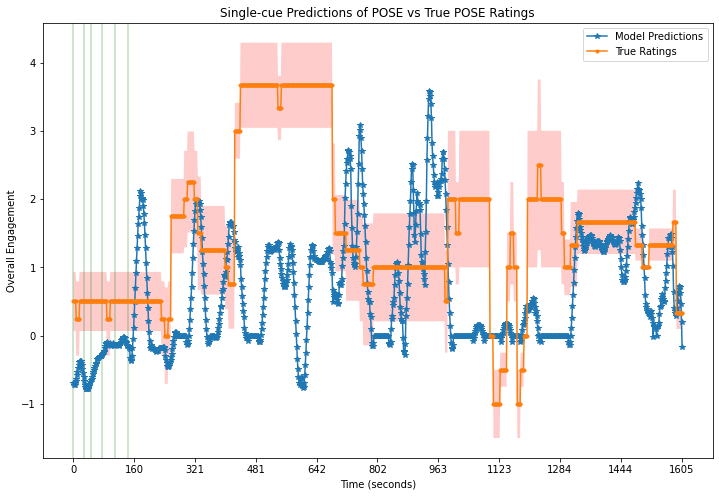

torch.Size([127])
[3, 4, 4, 4, 4, 4, 4, 4]
tensor([-6.6730e-04,  2.6567e-01,  6.7729e-01,  1.0653e+00,  1.2034e+00,
         7.5915e-02,  6.9001e-01,  9.8882e-01], device='cuda:0')

torch.Size([8])
torch.Size([8])


8


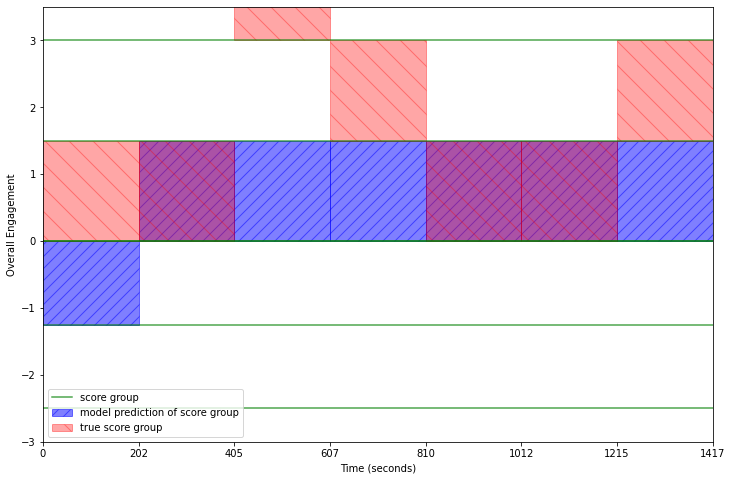

RuntimeError: ignored

In [ ]:
test_dataset =  VisualFeatureDatasetLSTMfromDF("pose", "test", path_frames, path_labels, 
                                               VA=False, augment=False, transform = False, 
                                               align=False, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("body3", 'pose', test_dataset, smoothen=True, net_type='regression')
eval_single_cue_with_score_classes("body3", 'pose', test_dataset, smoothen=True)


load from dataframe - raw frames
torch.Size([1086])
torch.Size([1086])
torch.Size([1086, 1, 67, 3])
torch.Size([121, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([121, 9, 1, 67, 3])
torch.Size([121])
here
[0, 176, 361, 570, 747, 942, 1086]

Weigthed score for GRU_Att_body2_aligned_seq_9 for pose after smoothening: 0.5327170142770651
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: -0.125705678243432

CCC scores for GRU_Att_body2_aligned_seq_9 for pose on test set 
  on each video: [0.0012000592597211457, 0.0649094482437196, -0.09759698036268079, 0.20596110075559626, 0.0025250453294188985, -0.011515618538272187]
w_MSE scores for GRU_Att_body2_aligned_seq_9 for pose on test set 
  on each video: [0.6622725674869046, 0.5594172649115664, 0.6368786803533778, 0.7122798772139571, 0.5090246926036499, 0.03346227831823423]

MSE error for GRU_Att_body2_aligned_seq_9 on test set: 118.39990997314453
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 135

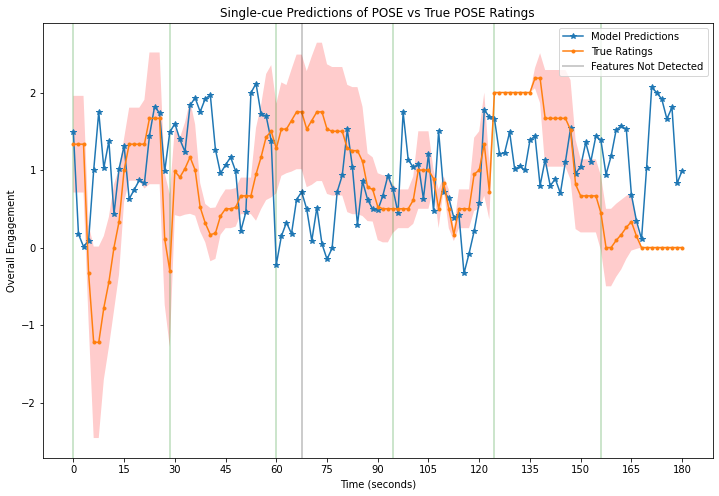


torch.Size([9])
torch.Size([9])
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: 0


MSE error for GRU_Att_body2_aligned_seq_9 on test set: 0.0
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 0
9
121


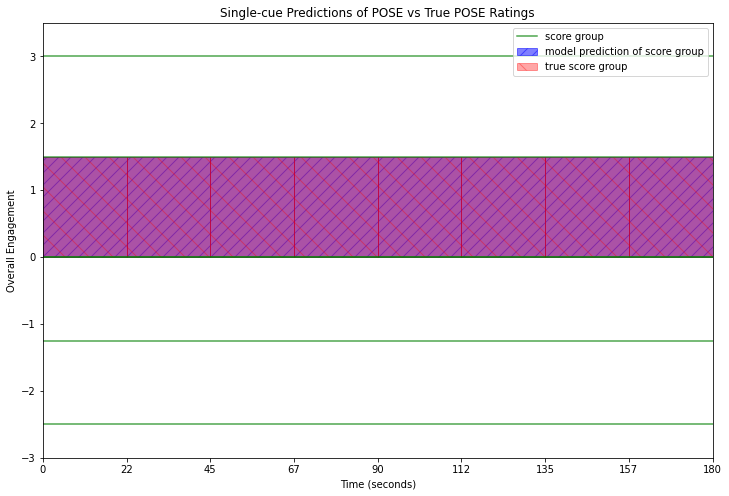

In [ ]:
test_dataset =  VisualFeatureDatasetLSTMfromDF("pose", "test", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=False)
eval_single_cue_with_score_classes("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)



load from dataframe - raw frames
torch.Size([720])
torch.Size([720])
torch.Size([720, 1, 67, 3])
torch.Size([81, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([81, 9, 1, 67, 3])
torch.Size([81])
0.07612419128417969

Weigthed score for GRU_Att_body2_aligned_seq_9 for pose after smoothening: 0.8800389848956401
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: 0.3486430550947528


MSE error for GRU_Att_body2_aligned_seq_9 on test set: 8.819766998291016
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 8.147748820394321
81
81


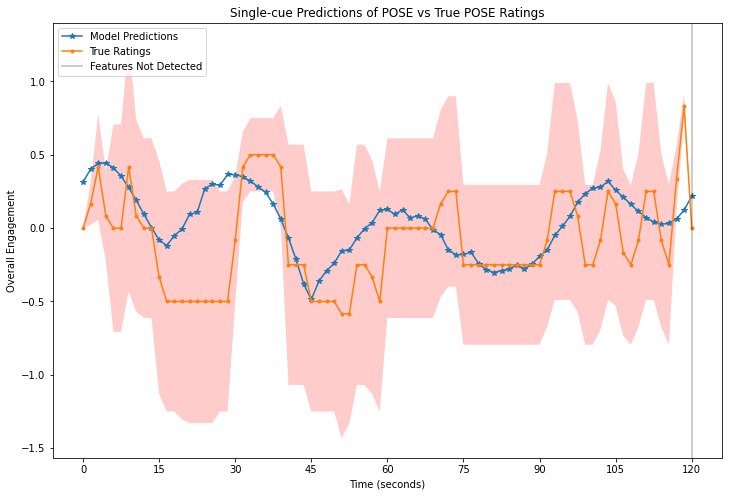


torch.Size([6])
torch.Size([6])
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: 0


MSE error for GRU_Att_body2_aligned_seq_9 on test set: 4.5
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 0
6
81


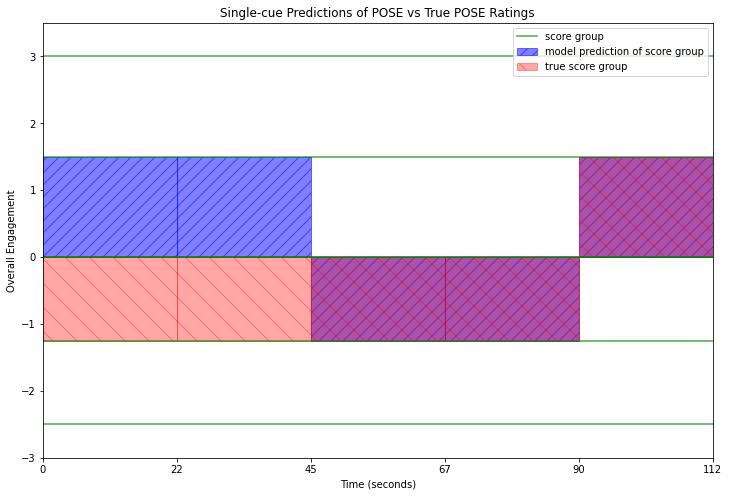

In [ ]:
test_dataset =  VisualFeatureDatasetLSTMfromDF("pose", "eval_video_1_whole", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)


## Batch 2

In [ ]:
# Set batch 2 data paths
path_labels=f'{content_path}/test_pipeline/opinions_visual.csv'
path_frames=f'{content_path}/test_pipeline/videos_eval/video_b2_'

seq_len = 9


load from dataframe - raw frames
torch.Size([1403])
torch.Size([1403])
torch.Size([1403, 1, 67, 3])
torch.Size([156, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([156, 9, 1, 67, 3])
torch.Size([156])
here
[0, 370, 724, 1114, 1403]

Weigthed score for GRU_Att_body2_aligned_seq_9 for pose after smoothening: 0.816657854101728
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: 0.3460267995156581

CCC scores for GRU_Att_body2_aligned_seq_9 for pose on test set 
  on each video: [0.2503414741422941, -0.20495751435735385, 0.1857775965415791, 0.05906393575470217]
w_MSE scores for GRU_Att_body2_aligned_seq_9 for pose on test set 
  on each video: [0.8556247138120849, 0.7818725879768063, 0.8468504009473459, 0.783877188561236]

MSE error for GRU_Att_body2_aligned_seq_9 on test set: 40.94203186035156
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 36.62545598327469
156
156


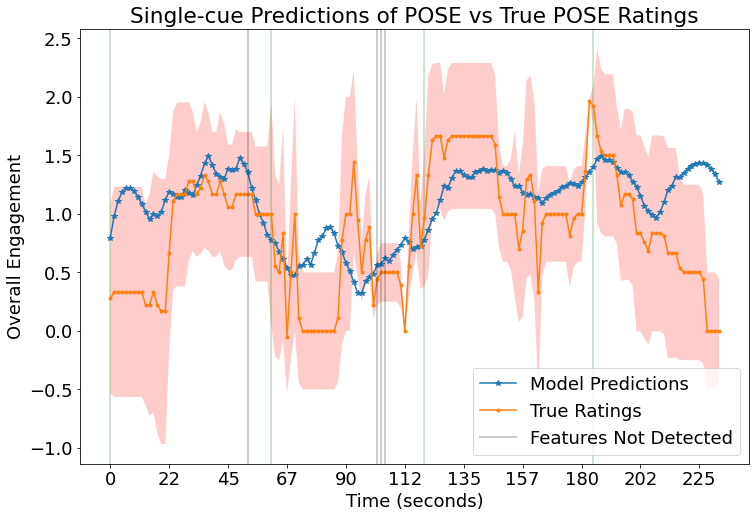


torch.Size([12])
torch.Size([12])
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: 0


MSE error for GRU_Att_body2_aligned_seq_9 on test set: 0.0
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 0
12
156


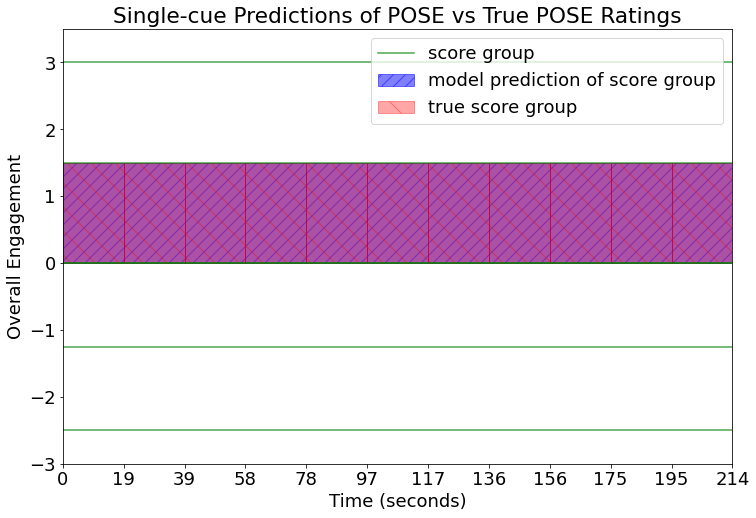

In [ ]:
test_dataset =  VisualFeatureDatasetLSTMfromDF("pose", "validation", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)



load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 67, 3])
torch.Size([242, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([242, 9, 1, 67, 3])
torch.Size([242])
here
[0, 350, 720, 1136, 1490, 1880, 2169]

Weigthed score for GRU_Att_body2_aligned_seq_9 for pose after smoothening: 0.7163859815223456
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: -0.08566748153358915

CCC scores for GRU_Att_body2_aligned_seq_9 for pose on test set 
  on each video: [-0.04051570986828231, 0.09798081216841355, -0.07618970209763154, -0.21721843541493652, 0.18977206800797067, 0.07365617309663282]
w_MSE scores for GRU_Att_body2_aligned_seq_9 for pose on test set 
  on each video: [0.6414832882797048, 0.8427519271971882, 0.4555256737640426, 0.7808789110655419, 0.8519078556420105, 0.7714459905419327]

MSE error for GRU_Att_body2_aligned_seq_9 on test set: 168.0664825439453
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 147

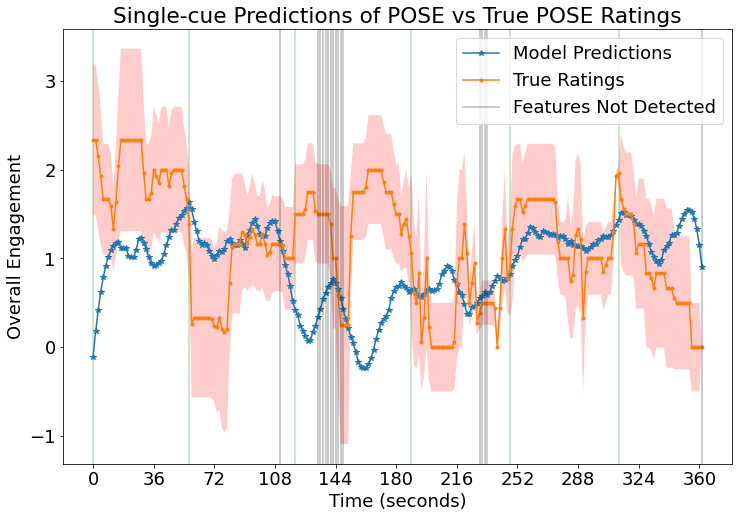


torch.Size([13])
torch.Size([13])
CCC score for GRU_Att_body2_aligned_seq_9 for pose on test set: 0


MSE error for GRU_Att_body2_aligned_seq_9 on test set: 6.75
weighted MSE error for GRU_Att_body2_aligned_seq_9 on test set: 0
13
242


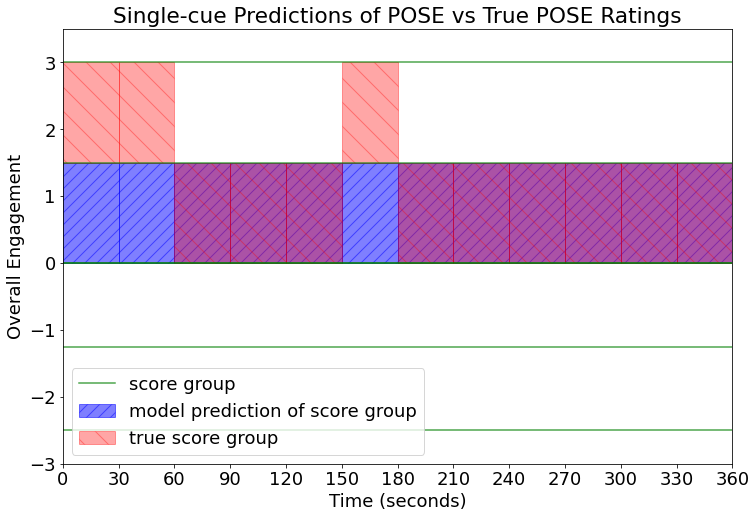

In [ ]:
test_dataset =  VisualFeatureDatasetLSTMfromDF("pose", "validation", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("GRU_Att_body2_aligned_seq_9", 'pose', test_dataset, smoothen=True)

#Face

Here we obtain the results for the FACE feature for each batch, using multiple tests. Passing the second argument in the VisualFeatureDatasetLSTMfromDF generates a partition of the dataset

## Batch 1

In [ ]:
# Set HyperParams
batch_size = 32
seq_len = 9
va_padding = 0
VA=False
model_name=  "BGRU_Att_face_align_seq_of_9"

# Set batch 1 data paths
path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'


load from dataframe - raw frames
torch.Size([7492])
torch.Size([7492])
torch.Size([7492, 1, 70, 3])
torch.Size([833, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([833, 9, 1, 70, 3])
torch.Size([833])
here
[0, 1201, 1982, 3221, 4607, 6039, 7492]

Weigthed score for BGRU_Att_face_align_seq_of_9 for face after smoothening: 0.32908272991865495
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: -0.2804177217936747

CCC scores for BGRU_Att_face_align_seq_of_9 for face on test set 
  on each video: []
w_MSE scores for BGRU_Att_face_align_seq_of_9 for face on test set 
  on each video: []

MSE error for BGRU_Att_face_align_seq_of_9 on test set: 3708.890869140625
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 2613.680515791467
833
833


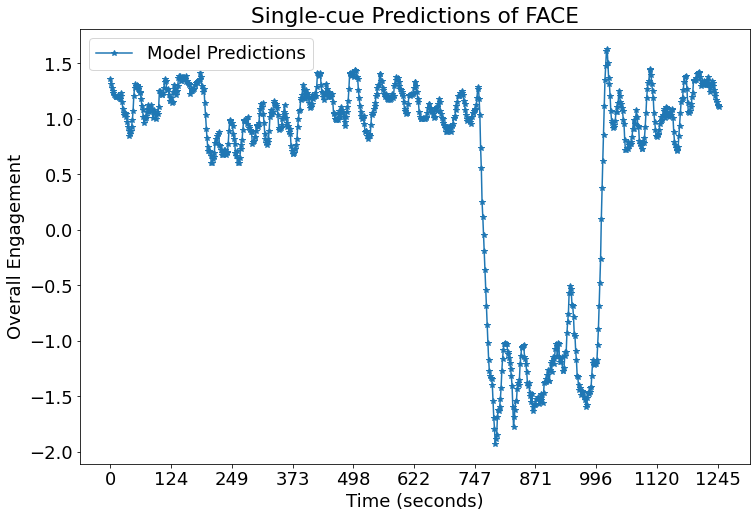


torch.Size([13])
torch.Size([13])
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 33.9375
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 0
13
833


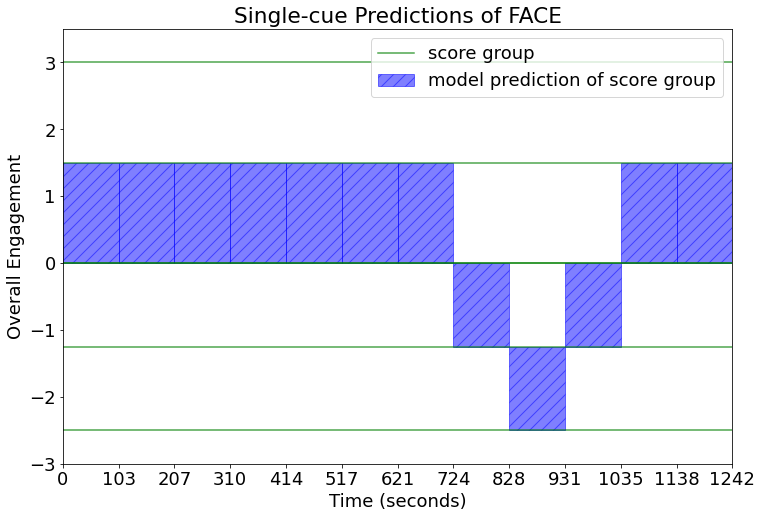

In [ ]:
test_dataset = VisualFeatureDatasetLSTMfromDF("face", "training", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

eval_single_cue(model_name, 'face', test_dataset, 
                smoothen=True, show_true_label=False)

eval_single_cue_with_score_classes(model_name, 'face', 
                                   test_dataset, smoothen=True, 
                                   show_true_label=False)


## Batch 2

In [ ]:
# Set batch 2 data paths
path_labels=f'{content_path}/test_pipeline/opinions_visual.csv'
path_frames=f'{content_path}/test_pipeline/videos_eval/video_b2_'

### Augmentation Experiment

The following two cells involve a small experiment to observe the effect of data augmentation on the model performance

1753

load from dataframe - raw frames
torch.Size([1086])
torch.Size([1086])
torch.Size([1086, 1, 70, 3])
torch.Size([121, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([121, 9, 1, 70, 3])
torch.Size([121])
here
[0, 176, 361, 570, 747, 942, 1086]

Weigthed score for BGRU_Att_face_align_seq_of_9 for face after smoothening: 0.6819178848631295
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0.1339958253096369

CCC scores for BGRU_Att_face_align_seq_of_9 for face on test set 
  on each video: [-0.09143989116875971, 0.44322372444607666, -0.01292303134774563, -0.07096566607923467, 0.12366588480572871, -0.31992342465010387]
w_MSE scores for BGRU_Att_face_align_seq_of_9 for face on test set 
  on each video: [0.6585654442853792, 0.8634744843021467, 0.6869518719623147, 0.7289054531187781, 0.36753274151527526, 0.8133008862891475]

MSE error for BGRU_Att_face_align_seq_of_9 on test set: 83.37149047851562
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test 

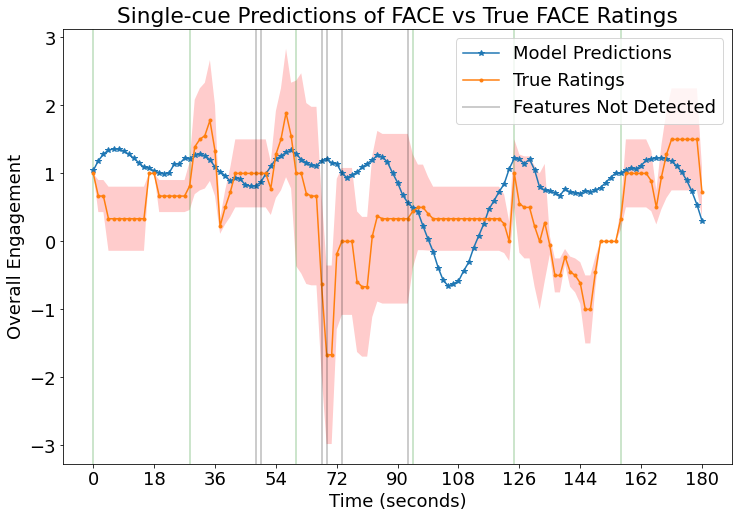


torch.Size([13])
torch.Size([13])
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 9.0
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 0
13
121


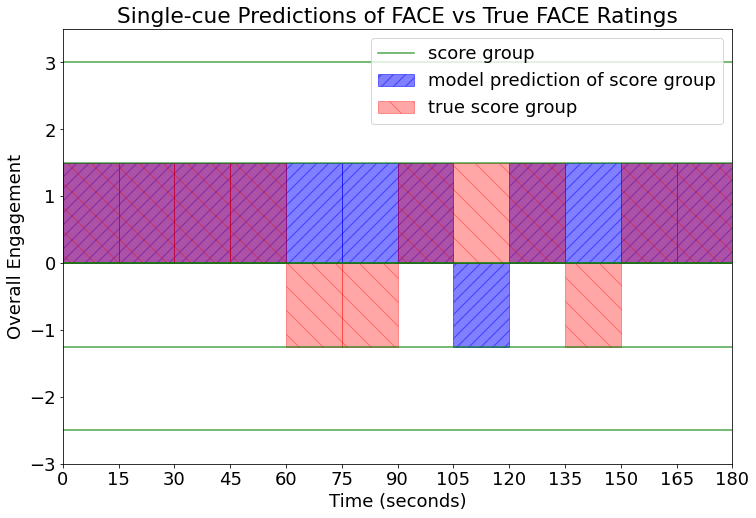

In [ ]:
# without augmentation
test_dataset =  VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("BGRU_Att_face_align_seq_of_9", 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("BGRU_Att_face_align_seq_of_9", 'face', test_dataset, smoothen=True)



load from dataframe - raw frames
torch.Size([1086])
torch.Size([1086])
torch.Size([1086, 1, 70, 3])
torch.Size([121, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([121, 9, 1, 70, 3])
torch.Size([121])
here
[0, 176, 361, 570, 747, 942, 1086]

Weigthed score for BGRU_Att_face_align_seq_of_9_old for face after smoothening: 0.7771820185252639
CCC score for BGRU_Att_face_align_seq_of_9_old for face on test set: 0.3332839652359378

CCC scores for BGRU_Att_face_align_seq_of_9_old for face on test set 
  on each video: [-0.40600177686264033, 0.28483647463366213, -0.024519284672797393, -0.11262741600669814, 0.7093190095412863, 0.18676654148284708]
w_MSE scores for BGRU_Att_face_align_seq_of_9_old for face on test set 
  on each video: [0.725771839671511, 0.828452223910428, 0.7110946229033497, 0.7344989368689565, 0.8288659323825954, 0.8433736953249356]

MSE error for BGRU_Att_face_align_seq_of_9_old on test set: 55.352867126464844
weighted MSE error for BGRU_Att_face_align_seq_o

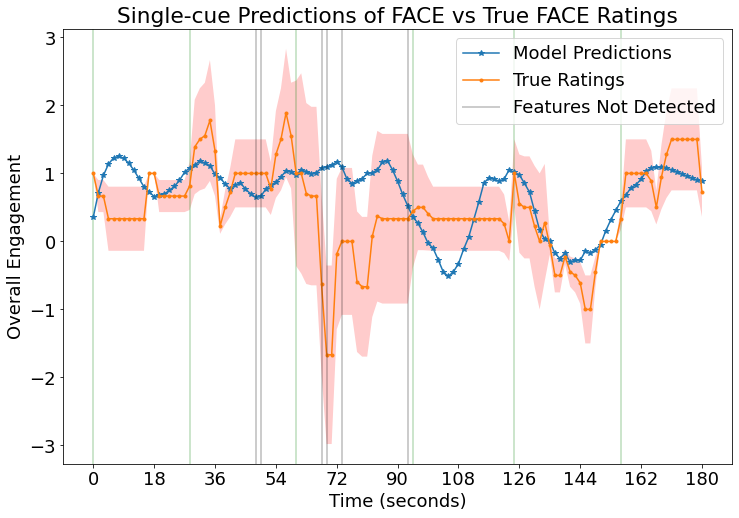


torch.Size([13])
torch.Size([13])
CCC score for BGRU_Att_face_align_seq_of_9_old for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9_old on test set: 4.5
weighted MSE error for BGRU_Att_face_align_seq_of_9_old on test set: 0
13
121


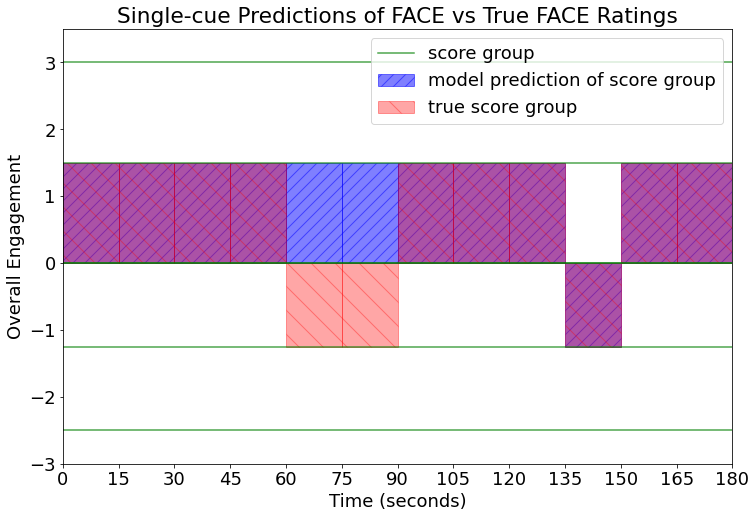

In [ ]:
# with augmentation
test_dataset =  VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("BGRU_Att_face_align_seq_of_9_old", 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("BGRU_Att_face_align_seq_of_9_old", 'face', test_dataset, smoothen=True)



load from dataframe
torch.Size([877])
torch.Size([877])
torch.Size([877, 1, 70, 3])
here
torch.Size([98, 9, 1, 70, 3])
torch.Size([98])

Weigthed score for BGRU_Att_face_align_seq_of_9 for face after smoothening: 0.7766909777390897
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0.5650930994261587


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 25.696331024169922
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 26.152976981355245
98
98


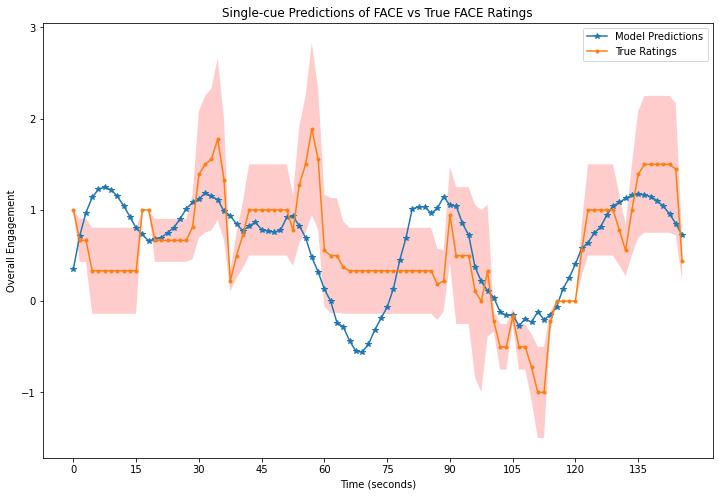


torch.Size([7])
torch.Size([7])
CCC score for BGRU_Att_face_align_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_seq_of_9 on test set: 2.25
weighted MSE error for BGRU_Att_face_align_seq_of_9 on test set: 0
7
98


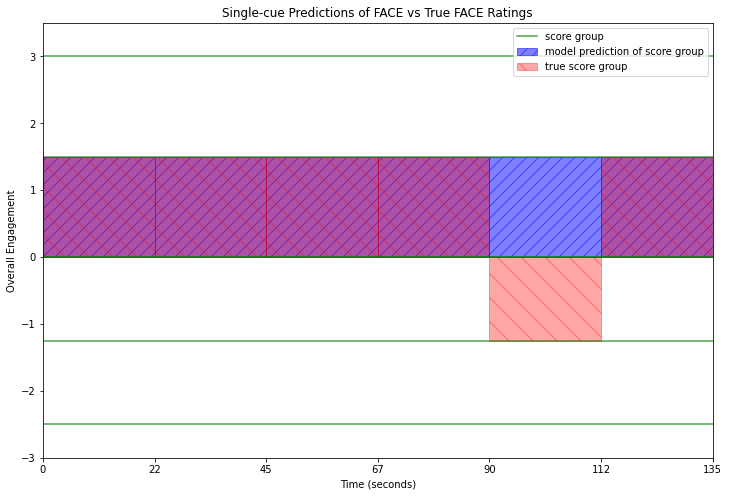

In [ ]:
test_dataset =  VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                               VA=False, augment=False, transform = True, 
                                               align=True, frames_per_seq= seq_len, 
                                               device=device)

eval_single_cue("BGRU_Att_face_align_seq_of_9", 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("BGRU_Att_face_align_seq_of_9", 'face', test_dataset, smoothen=True)


### Batch Training Comparison

In the following two cells we re-train and evaluate the face models on both batch 1 data and bacth 2 data to observe the differences in performance.


load from dataframe - raw frames
torch.Size([7492])
torch.Size([7492])
torch.Size([7492, 1, 70, 3])
torch.Size([833, 9, 1, 70, 3])
good 55
n_good 446
n_bad 203
bad 129

here - number of sequences for face
torch.Size([1201, 9, 1, 70, 3])
torch.Size([1201])

load from dataframe - raw frames
torch.Size([2140])
torch.Size([2140])
torch.Size([2140, 1, 70, 3])
torch.Size([238, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([238, 9, 1, 70, 3])
torch.Size([238])

load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])
torch.Size([9, 210])
cuda
Epoch: 0, Iteration: 0, training loss = 62.3281
Epoch: 0, Iteration: 10, training loss = 93.4526
Epoch: 0, Iteration: 20, training loss = 79.1615
Epoch: 0, Iteration: 30, training loss = 111.6484
Epoch: 10, Iteration: 0, training loss = 64.3844
Epoch: 10, Iteration: 10, training l

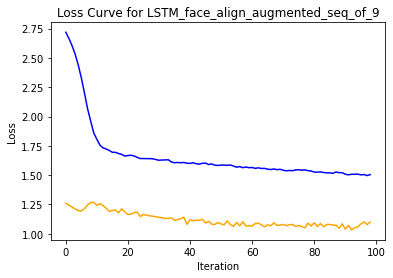


Weigthed score for LSTM_face_align_augmented_seq_of_9 for face after smoothening: 0.4966803872365845
CCC score for LSTM_face_align_augmented_seq_of_9 for face on test set: 0.4616157664442047


MSE error for LSTM_face_align_augmented_seq_of_9 on test set: 179.68411254882812
weighted MSE error for LSTM_face_align_augmented_seq_of_9 on test set: 157.67494239993863
120
120


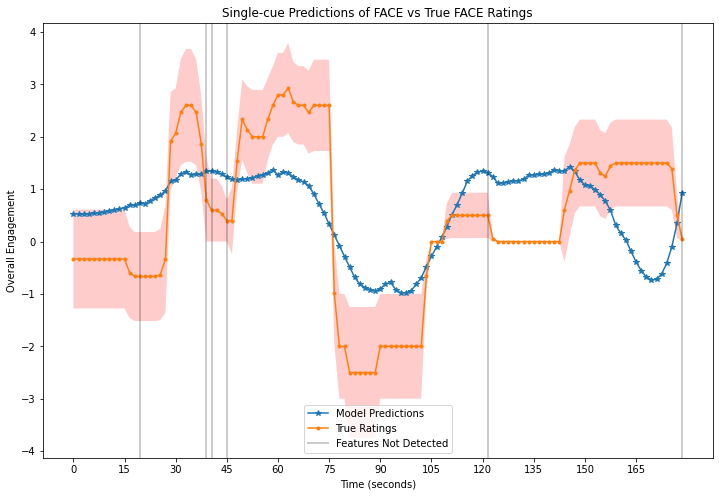


torch.Size([8])
torch.Size([8])
CCC score for LSTM_face_align_augmented_seq_of_9 for face on test set: 0


MSE error for LSTM_face_align_augmented_seq_of_9 on test set: 6.75
weighted MSE error for LSTM_face_align_augmented_seq_of_9 on test set: 0
8
120


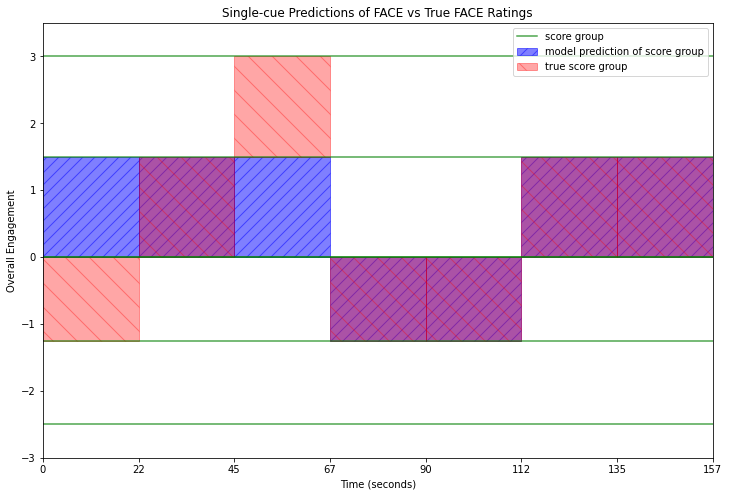

In [ ]:
# Set Dataset hyperparams
batch_size = 32
seq_len = 9
va_padding = 0
VA=False

# Set batch 1 data
path_labels=f'{content_path}/video_features/opinions_visual.csv'
path_frames=f'{content_path}/video_features/video_b1_'

train_dataset = VisualFeatureDatasetLSTMfromDF("face", "training", path_frames, path_labels, 
                                               VA=False, augment=True, transform=True , 
                                               align=True, frames_per_seq=seq_len, device=device)
valid_dataset = VisualFeatureDatasetLSTMfromDF("face", "validation", path_frames, path_labels, 
                                               VA=False, augment=False, transform=True , 
                                               align=True, frames_per_seq=seq_len, device=device)
test_dataset = VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)
     
# Set model hyperparams
print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

input_dim = (70 + va_padding)*3

output_dim = 1
# hidden_dim = 64
hidden_dim = 32
layer_dim = 3
learning_rate = 0.00005
model_name = "LSTM_face_align_augmented_seq_of_9"
model_type = "LSTM"
num_epochs = 100
valid_freq = 1
patience = 5
bidir=False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = LSTMModel(input_dim, hidden_dim, layer_dim, 
                     output_dim, device, dropout_prob=0.2, bidir=bidir)
      
# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='w_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

# gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)
eval_single_cue(model_name, 'face', test_dataset, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)



load from dataframe
torch.Size([6130])
torch.Size([6130])
torch.Size([6130, 1, 70, 3])
good 8
n_good 423
n_bad 251
bad 0
torch.Size([682, 9, 1, 70, 3])
here
torch.Size([965, 9, 1, 70, 3])
torch.Size([965])

load from dataframe
torch.Size([1753])
torch.Size([1753])
torch.Size([1753, 1, 70, 3])
here
torch.Size([195, 9, 1, 70, 3])
torch.Size([195])

load from dataframe
torch.Size([877])
torch.Size([877])
torch.Size([877, 1, 70, 3])
here
torch.Size([98, 9, 1, 70, 3])
torch.Size([98])
torch.Size([9, 210])
cuda

Weigthed score for BGRU_Att_face_align_augmented_seq_of_9 for face after smoothening: 0.572077853557198
CCC score for BGRU_Att_face_align_augmented_seq_of_9 for face on test set: -0.4815265697316205


MSE error for BGRU_Att_face_align_augmented_seq_of_9 on test set: 85.63623809814453
weighted MSE error for BGRU_Att_face_align_augmented_seq_of_9 on test set: 98.04061281842493
98
98


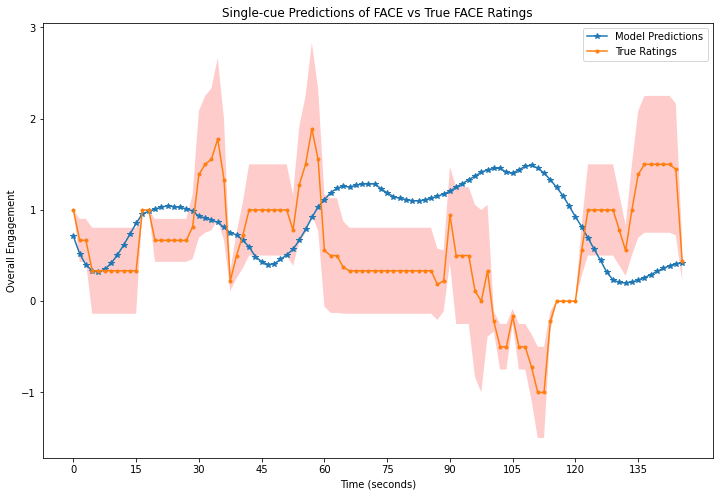


torch.Size([7])
torch.Size([7])
CCC score for BGRU_Att_face_align_augmented_seq_of_9 for face on test set: 0


MSE error for BGRU_Att_face_align_augmented_seq_of_9 on test set: 2.25
weighted MSE error for BGRU_Att_face_align_augmented_seq_of_9 on test set: 0
7
98


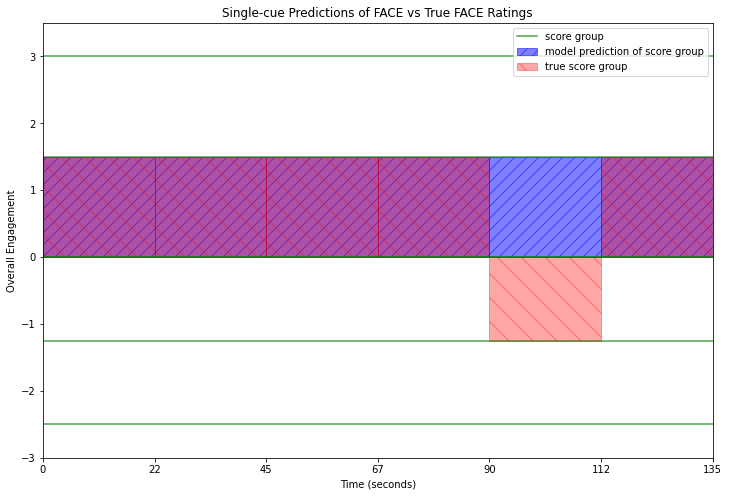

In [ ]:
# Dataset Hyperparams
batch_size = 32
seq_len = 9
va_padding = 0
VA=False

# Set batch 2 data
path_labels=f'{content_path}/test_pipeline/opinions_visual.csv'
path_frames=f'{content_path}/test_pipeline/videos_eval/video_b2_'

train_dataset = VisualFeatureDatasetLSTMfromDF("face", "training", path_frames, path_labels, 
                                               VA=False, augment=True, transform=True , 
                                               align=True, frames_per_seq=seq_len, device=device)
valid_dataset = VisualFeatureDatasetLSTMfromDF("face", "validation", path_frames, path_labels, 
                                               VA=False, augment=False, transform=True , 
                                               align=True, frames_per_seq=seq_len, device=device)
test_dataset = VisualFeatureDatasetLSTMfromDF("face", "test", path_frames, path_labels, 
                                              VA=False, augment=False, transform=True , 
                                              align=True, frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

# model hyperparams     
print(train_dataset[0][0].shape)     
seq_dim = train_dataset[0][0].shape[0]

input_dim = (70 + va_padding)*3

output_dim = 1
# hidden_dim = 64
hidden_dim = 50
layer_dim = 3
learning_rate = 0.00001
model_name = "BGRU_Att_face_align_augmented_seq_of_9"
model_type = "GRU_Att"
num_epochs = 100
valid_freq = 5
patience = 5
bidir=True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
# criterion = nn.MSELoss(reduction='sum')
# criterion = lambda out, res, std : torch.sum(2/(1+std) * (out - res.float()) ** 2)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_for_feat_datasetLSTM(model, 
                       (model_name, "face", model_type), 
                       train_loader, 
                       valid_loader, 
                       criterion='w_MSE', 
                       optimiser=optimiser, 
                       device=device, 
                       num_epochs=num_epochs, 
                       valid_freq=valid_freq,
                       VA=(VA, va_padding),
                       patience_threshold=patience)

# gen_feat_graph_and_score(model_name, "face", model_type = model_type, VA=VA, frames_per_seq=seq_len, show_graph=True)
eval_single_cue(model_name, 'face', test_dataset, batch_size=batch_size, smoothen=True)
eval_single_cue_with_score_classes(model_name, 'face', test_dataset, smoothen=True)


### Valence Arousal Extraction Experiment
Here we try to extract valence arousal descriptors for the face

In [ ]:
# !pip install deepface
# from deepface import DeepFace

# execfile(f'{content_path}/va_extractor_model/VA_face/run_pretrained_model.py')

# img_path = f"{content_path}/frames/test_frames/GF2 (1).png" 

def extract_va(path):
  for i in range(1, 7):
    folder = f'{path}{i}/frames' 

    if not os.path.exists(f'/aligned_frames/'):
      print('creating file')
      os.mkdir(f'/aligned_frames/')

    for j, img_name in enumerate(os.listdir(folder)):
      print(img_name)
      if img_name[-3:] not in ['png', 'jpg']:
        continue
      img = f'{folder}/{img_name}'
      print(img)
      pic = cv2.imread(img)
      try:
        face = DeepFace.detectFace(pic)
      except KeyboardInterrupt:
        print('Interrupted')
      except:
        print(f'{img_name} does not contain a face')

      if j%100 == 0:
        plt.imshow(face)
      # print(f'{folder}/aligned_frames/{img_name}')
      plt.imsave(f'/aligned_frames/{img_name}', face)

path =f'{content_path}/test_pipeline/videos_eval/video_b2_'
extract_va(path)

#Voice

Here we obtain the results for the VOICE feature for each batch, using multiple tests. Passing the second argument in the VocalSnippetDatasetfromDF generates a partition of the dataset

## Batch 1

### Batch Size Experiment
Here we train the voice models on batch 1 data, with differing batch sizes (32 and 64) and compare the performance.

1192

here - number of audio sequences
830
1192

here - number of audio sequences
239
1192

here - number of audio sequences
122
Epoch: 0, Iteration: 0, training loss = 277.9315
Epoch: 0, Iteration: 1, training loss = 298.8410
Epoch: 0, Iteration: 2, training loss = 219.1304
Epoch: 0, Iteration: 3, training loss = 244.8204
Epoch: 0, Iteration: 4, training loss = 277.0871
Epoch: 0, Iteration: 5, training loss = 215.7523
Epoch: 0, Iteration: 6, training loss = 242.7083
Epoch: 0, Iteration: 7, training loss = 199.0264
Epoch: 0, Iteration: 8, training loss = 219.0201
Epoch: 0, Iteration: 9, training loss = 243.4662
Epoch: 0, Iteration: 10, training loss = 183.7254
Epoch: 0, Iteration: 11, training loss = 212.8073
Epoch: 0, Iteration: 12, training loss = 187.1814
Epoch: 0, Iteration: 0, valid loss = 225.8324
Epoch: 0, Iteration: 1, valid loss = 95.3518
Epoch: 0, Iteration: 2, valid loss = 42.1726
Epoch: 0, Iteration: 3, valid loss = 125.6131
Epoch: 1, Iteration: 0, training loss = 208.8031


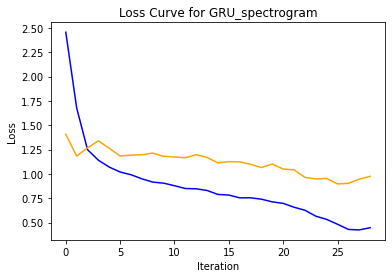


Weigthed score for GRU_spectrogram for voice after smoothening: 0.48079081584474304
CCC score for GRU_spectrogram for voice on test set: 0.32996197067815186


MSE error for GRU_spectrogram on test set: 253.0862274169922
weighted MSE error for GRU_spectrogram on test set: 222.88600082216595
122
122
no empty frames


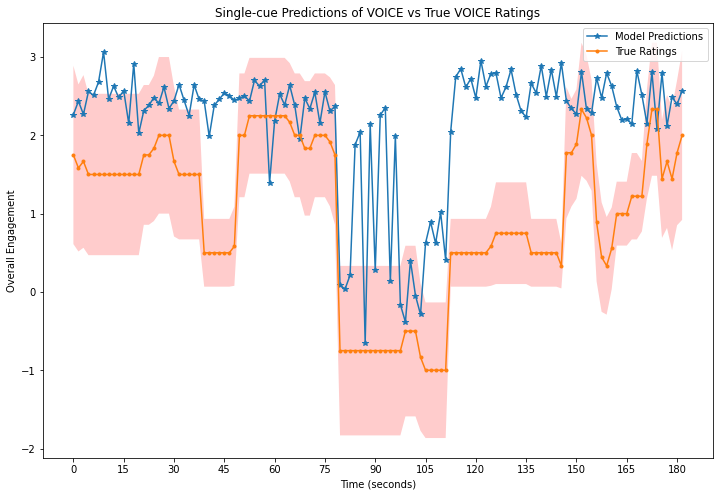


torch.Size([9])
torch.Size([9])
CCC score for GRU_spectrogram for voice on test set: 0


MSE error for GRU_spectrogram on test set: 13.5
weighted MSE error for GRU_spectrogram on test set: 0
9
122


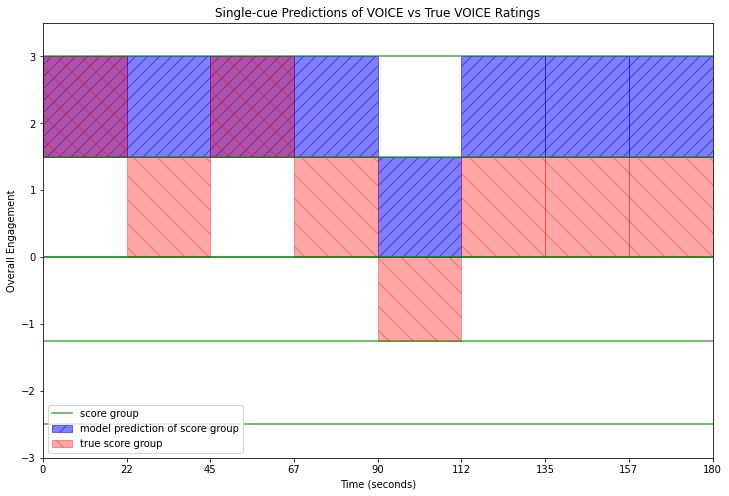

In [ ]:
VA_available = False
batch_size = 64

path_labels = f"{content_path}/dataset/audio/opinions_audio.csv"
path_audio = f"{content_path}/dataset/audio/"

train_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "training", 
                                           transform=True, VA=VA_available)
valid_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "validation", 
                                           transform=True, VA=VA_available)

test_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "test",
                                          transform=True, VA=VA_available)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)



valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

output_dim = 1
hidden_dim = 64
layer_dim = 2
learning_rate = 0.0003
model_name = "GRU_spectrogram"
model_type = "GRU_Att"
num_epochs = 50
valid_freq = 1
patience = 3
seq_dim, input_dim = train_dataset[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"
bidir=True

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader,
                        'weighted_MSE', optimiser, device, num_epochs,
                        valid_freq, VA=False, patience_threshold=patience)

eval_single_cue(model_name, 'voice', test_dataset, smoothen=False)
eval_single_cue_with_score_classes(model_name, 'voice', test_dataset, smoothen=True)

1192

here - number of audio sequences
830
1192

here - number of audio sequences
239
1192

here - number of audio sequences
122
Epoch: 0, Iteration: 0, training loss = 144.9332
Epoch: 0, Iteration: 1, training loss = 132.4464
Epoch: 0, Iteration: 2, training loss = 93.9295
Epoch: 0, Iteration: 3, training loss = 82.1199
Epoch: 0, Iteration: 4, training loss = 70.2173
Epoch: 0, Iteration: 5, training loss = 53.0324
Epoch: 0, Iteration: 6, training loss = 61.0383
Epoch: 0, Iteration: 7, training loss = 44.6718
Epoch: 0, Iteration: 8, training loss = 37.9396
Epoch: 0, Iteration: 9, training loss = 30.5354
Epoch: 0, Iteration: 10, training loss = 36.8105
Epoch: 0, Iteration: 11, training loss = 29.0170
Epoch: 0, Iteration: 12, training loss = 31.6660
Epoch: 0, Iteration: 13, training loss = 24.7311
Epoch: 0, Iteration: 14, training loss = 31.3897
Epoch: 0, Iteration: 15, training loss = 28.5927
Epoch: 0, Iteration: 16, training loss = 28.3221
Epoch: 0, Iteration: 17, training loss = 27.60

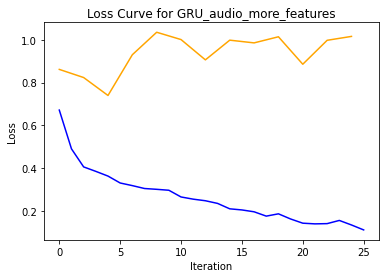


Weigthed score for GRU_audio_more_features for voice after smoothening: 0.5400637199235291
CCC score for GRU_audio_more_features for voice on test set: 0.5446776410327093


MSE error for GRU_audio_more_features on test set: 182.5839080810547
weighted MSE error for GRU_audio_more_features on test set: 169.89952249720972
122
122
no empty frames


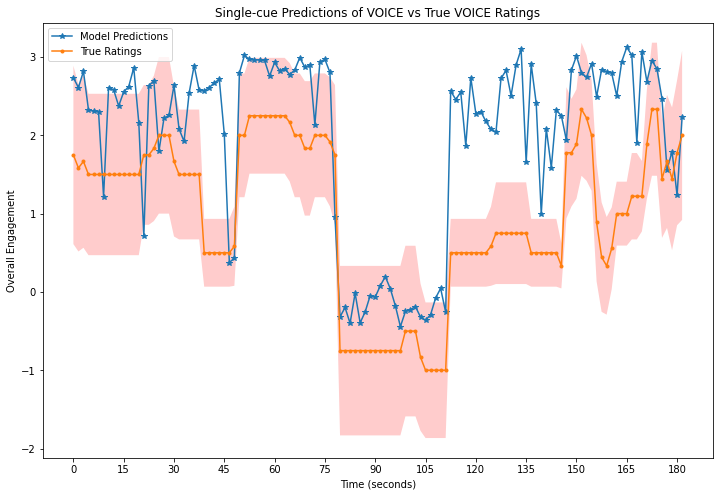


torch.Size([9])
torch.Size([9])
CCC score for GRU_audio_more_features for voice on test set: 0


MSE error for GRU_audio_more_features on test set: 9.0
weighted MSE error for GRU_audio_more_features on test set: 0
9
122


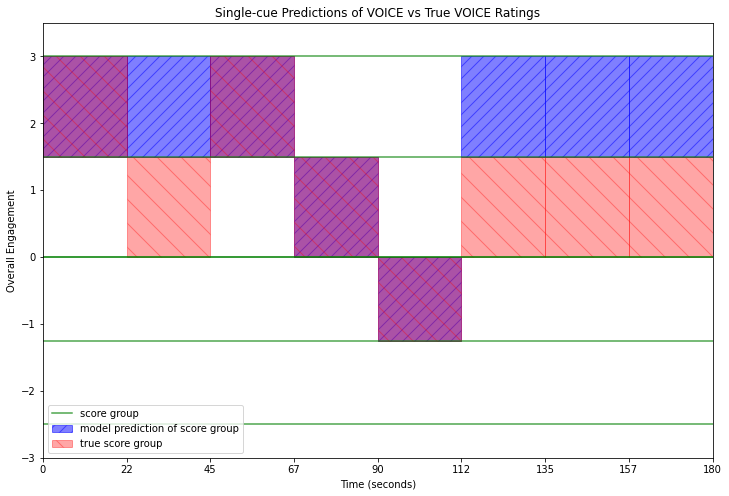

In [ ]:
VA_available = False
batch_size = 32

path_labels = f"{content_path}/dataset/audio/opinions_audio.csv"
path_audio = f"{content_path}/dataset/audio/"

train_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "training", 
                                           transform=True, VA=VA_available)
valid_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "validation", 
                                           transform=True, VA=VA_available)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

output_dim = 1
hidden_dim = 100
layer_dim = 2
learning_rate = 0.0003
model_name = "GRU_audio_more_features"
model_type = "GRU_Att"
num_epochs = 50
valid_freq = 1
patience = 3
seq_dim, input_dim = train_dataset[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"
bidir=True

model = GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim, device, dropout_prob=0.2, bidir=bidir)
      
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_for_audio_dataset(model, model_name, train_loader, valid_loader,
                        'weighted_MSE', optimiser, device, num_epochs,
                        valid_freq, VA=False, patience_threshold=patience)

eval_single_cue(model_name, 'voice', test_dataset, smoothen=False)
eval_single_cue_with_score_classes(model_name, 'voice', test_dataset, smoothen=True)

## Batch 2

In [ ]:
# Dataset Hyperparams
VA_available = False
batch_size = 64

# Set batch 2 data
path_labels=f'{content_path}/test_pipeline/opinions_audio.csv'
path_audio=f'{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments'

1215

here - number of audio sequences
123
here
[0, 20, 41, 65, 85, 107, 123]

Weigthed score for GRU_voice_va_short_seq for voice after smoothening: 0.35809090259804066
CCC score for GRU_voice_va_short_seq for voice on test set: 0.2599967059884665

CCC scores for GRU_voice_va_short_seq for voice on test set 
  on each video: [0.02318234695505089, -0.2737804462848357, 0.06309341260858291, -0.1763885246699667, 0.05685281546171347, -0.07531380633121355]
w_MSE scores for GRU_voice_va_short_seq for voice on test set 
  on each video: [0.5075569326299079, 0.42170393435536846, 0.5139342540604409, 0.33003566027633724, 0.0820590244702677, 0.268614119010931]

MSE error for GRU_voice_va_short_seq on test set: 322.59844970703125
weighted MSE error for GRU_voice_va_short_seq on test set: 304.1382006631503
123
123
no empty frames


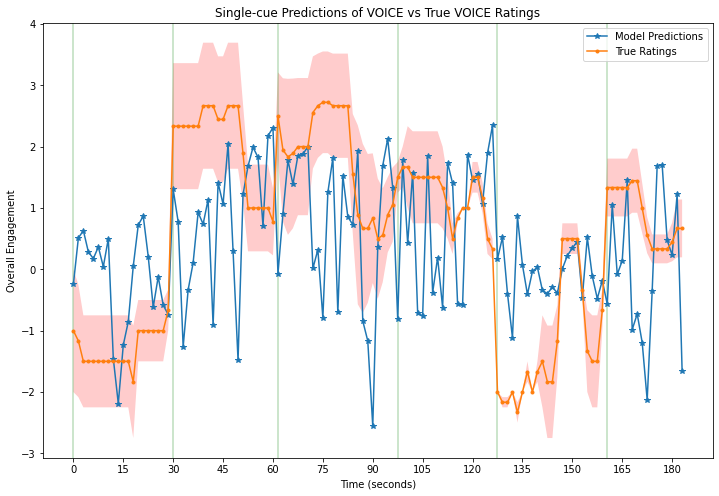


torch.Size([9])
torch.Size([9])
CCC score for GRU_voice_va_short_seq for voice on test set: 0


MSE error for GRU_voice_va_short_seq on test set: 10.5625
weighted MSE error for GRU_voice_va_short_seq on test set: 0
9
123


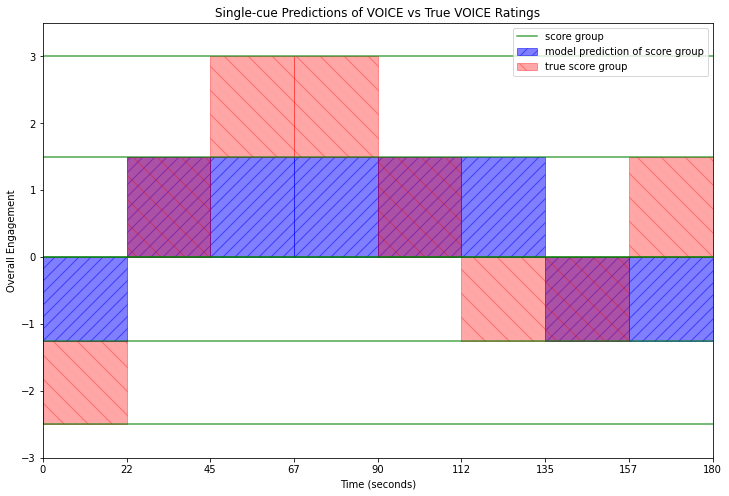

In [ ]:
# Without smoothing
test_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "test",
                                          transform=True, VA=VA_available)

eval_single_cue("GRU_voice_va_short_seq", 'voice', test_dataset, smoothen=False)
eval_single_cue_with_score_classes("GRU_voice_va_short_seq", 'voice', test_dataset, smoothen=True)


1215

here - number of audio sequences
123

Weigthed score for GRU_voice_va_short_seq for voice after smoothening: 0.45203342469642294
CCC score for GRU_voice_va_short_seq for voice on test set: 0.3117342865653857


MSE error for GRU_voice_va_short_seq on test set: 223.13551330566406
weighted MSE error for GRU_voice_va_short_seq on test set: 219.34789596514412
123
123
no empty frames


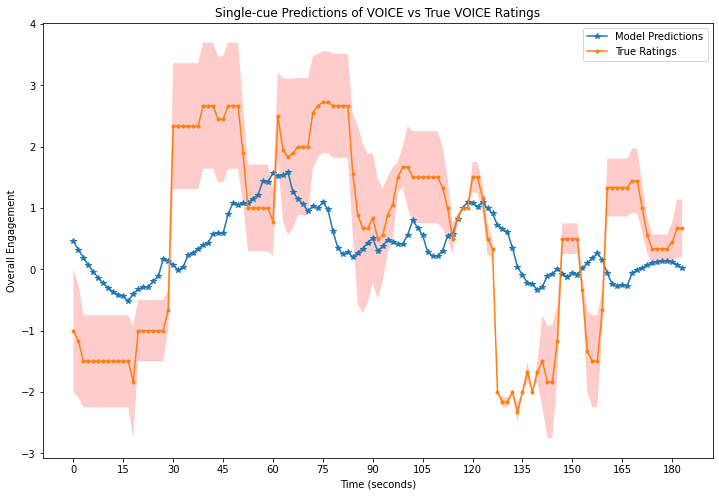


torch.Size([9])
torch.Size([9])
CCC score for GRU_voice_va_short_seq for voice on test set: 0


MSE error for GRU_voice_va_short_seq on test set: 10.5625
weighted MSE error for GRU_voice_va_short_seq on test set: 0
9
123


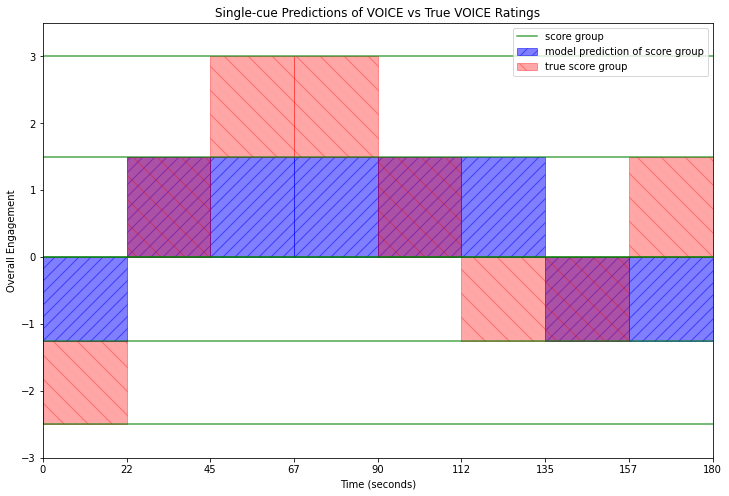

In [ ]:
# With smoothing
test_dataset = VocalSnippetsDatasetfromDF(path_labels, path_audio, "test",
                                          transform=True, VA=VA_available)

eval_single_cue("GRU_voice_va_short_seq", 'voice', test_dataset, smoothen=True)
eval_single_cue_with_score_classes("GRU_voice_va_short_seq", 'voice', test_dataset, smoothen=True)


# Hand-crafted Fusion (Baseline)


load from dataframe - raw frames
torch.Size([1086])
torch.Size([1086])
torch.Size([1086, 1, 70, 3])

here - number of sequences for face
torch.Size([121, 9, 1, 70, 3])
torch.Size([121])

load from dataframe - raw frames
torch.Size([1086])
torch.Size([1086])
torch.Size([1086, 1, 67, 3])

here - number of sequences for pose
torch.Size([121, 9, 1, 67, 3])
torch.Size([121])
1215

here - number of audio sequences
123
121
torch.Size([121])
here
torch.Size([121])
torch.Size([121])
here
[0, 176, 361, 570, 747, 942, 1086]
CCC scores for hand-crafted fusion on test set 
  on each video: [-0.20138982929130464, -0.0007370307469254497, -0.092848906588989, 0.016683601242725596, -0.03225327233847457, 0.0]
w_MSE scores for hand-crafted fusion on test set 
  on each video: [0.64079296386304, 0.5558130816771198, 0.49069322962219253, 0.35211394001825924, 0.3380634095121343, 0.7520740579424159]

Weigthed score for hand-crafted for fusion with attention after smoothening: 0.5077038494017609
CCC score for 

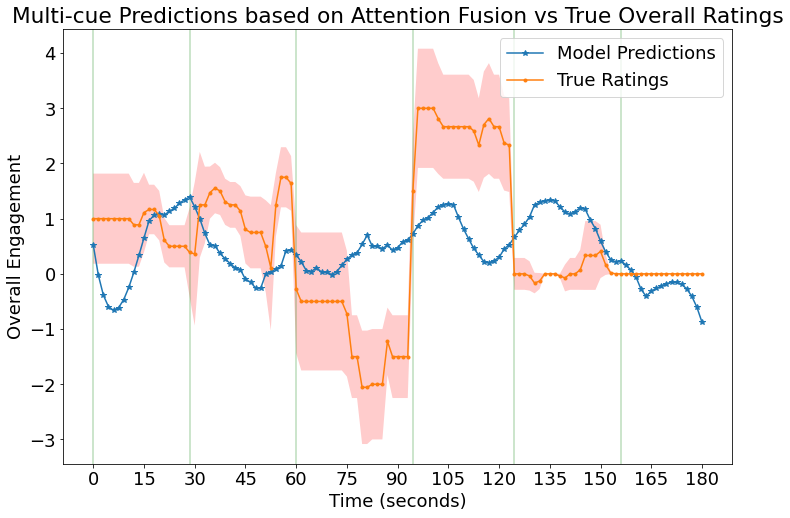

torch.Size([1])
[4, 4, 4, 4, 4, 4, 4, 3, 3]
tensor([ 0.1819,  0.7553,  0.0751,  0.3246,  0.9214,  0.6662,  0.8711, -0.2181,
        -0.8757], device='cuda:0', dtype=torch.float64)

torch.Size([9])
torch.Size([9])



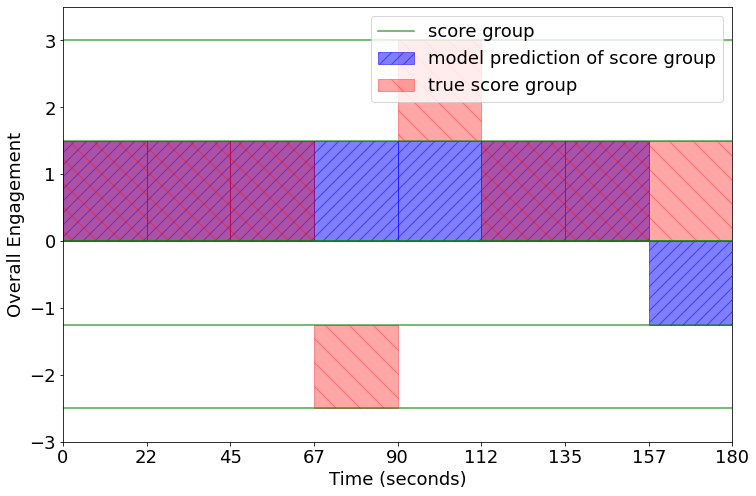

In [ ]:
seq_len=9
batch_size=1
video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

dataset="test"
import time

test_dataset = MultiModalDataset("test",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device,
                                 model_type='regression')

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

single_cue_networks = ("face4_VA", 
                       "body3",
                       "GRU_spectrogram") 

eval_fusion_regression(seq_len=9, 
                test_loader = test_loader,
                single_cue_nets=single_cue_networks,
                smoothen = True)

#Model-fusion
Here we train and obtain the predictions for model fusion for evaluation

## Training

cuda
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 0, Iteration: 0, training loss = 1.0361
Epoch: 1, Iteration: 0, training loss = 1.0051
Epoch: 2, Iteration: 0, training loss = 0.9659
Epoch: 3, Iteration: 0, training loss = 1.0312
Epoch: 4, Iteration: 0, training loss = 1.0295
Epoch: 5, Iteration: 0, training loss = 0.9823
Epoch: 6, Iteration: 0, training loss = 1.0017
Epoch: 7, Iteration: 0, training loss = 1.0253
Epoch: 8, Iteration: 0, training loss = 0.9738
Epoch: 9, Iteration: 0, training loss = 1.0363
Epoch: 10, Iteration: 0, training loss = 0.9952
Epoch: 11, Iteration: 0, training loss = 1.0298
Epoch: 12, Iteration: 0, training loss = 0.9949
Epoch: 13, Iteration: 0, training loss = 0.9717
Epoch: 14, Iteration: 0, training loss = 0.9603
Epoch: 15, Iteration: 0, training loss = 1.0204
Epoch: 16, Iteration: 0, training loss = 0.9978
Epoch: 17, Iteration: 0, training loss = 0.9736
Epoch: 18, Iteration: 0, training loss = 0.8979
Epoch: 19, Iteration: 0, training loss = 1.0073
Epoch: 20, Iteration: 0, training loss = 1.0208
Ep

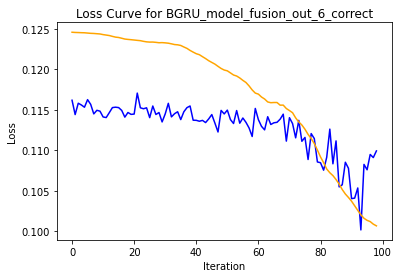

NameError: ignored

In [ ]:
# Dataset Hyperparams
va_padding = 1
VA=True
seq_len=9
batch_size=54

# Use Batch 1 data for training
video_label_path=f'{content_path}/video_features/opinions_visual.csv'
video_path=f'{content_path}/video_features/video_b1_'

audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
audio_path = f"{content_path}/dataset/audio/"

train_dataset = MultiModalDataset("training",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

valid_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                           shuffle=False)

# Model Parameters
hidden_dim = 45
layer_dim = 2
learning_rate = 0.00005
model_name = "BGRU_model_fusion_out_6_correct"
model_type = "GRU"
num_epochs = 100
valid_freq = 1
patience = 5
bidir=True
out_dim = 6

single_cue_networks = ("BGRU_Att_face_align_seq_of_9_copy", 
                       "GRU_Att_body2_aligned_seq_9_copy",
                       "GRU_voice_va_short_seq_copy") 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

f, _, _ = train_dataset.__getitem__(0)
input_dim = 3

model = torch.nn.Sequential(GRUModel_Att(input_dim, hidden_dim, layer_dim, output_dim = out_dim,
                     device=device, dropout_prob=0.2, bidir=bidir),
                     torch.nn.LeakyReLU(),
                     torch.nn.Linear(out_dim, out_dim))

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

single_cue_networks = ("BGRU_Att_face_align_seq_of_9_copy", 
                       "GRU_Att_body2_aligned_seq_9_copy",
                       "GRU_voice_va_short_seq_copy") 

train_model_fusion(model, model_name, train_loader, valid_loader,criterion= "CCC",
                      optimiser = optimiser, 
                      single_cue_nets=single_cue_networks,
                      device=device, valid_freq=valid_freq,
                      num_epochs = num_epochs,
                      patience_threshold=patience, 
                      seq_len = 6, out_seq = out_dim)

eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True)

## Evaluation

In [ ]:
import time

# Dataset Hparams
seq_len=9
batch_size=54

# Evaluate on Batch 2 data
video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"


load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 70, 3])
torch.Size([242, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([242, 9, 1, 70, 3])
torch.Size([242])

load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 67, 3])
torch.Size([242, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([242, 9, 1, 67, 3])
torch.Size([242])
1215

here - number of audio sequences
242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
7.117948770523071
here
torch.Size([246])
torch.Size([246])
here
[0, 350, 720, 1136, 1490, 1880, 2169]
CCC scores for BGRU_model_fusion_out_6_correct fusion on test set 
  on each video: [0.009033181704580784, -0.027052240

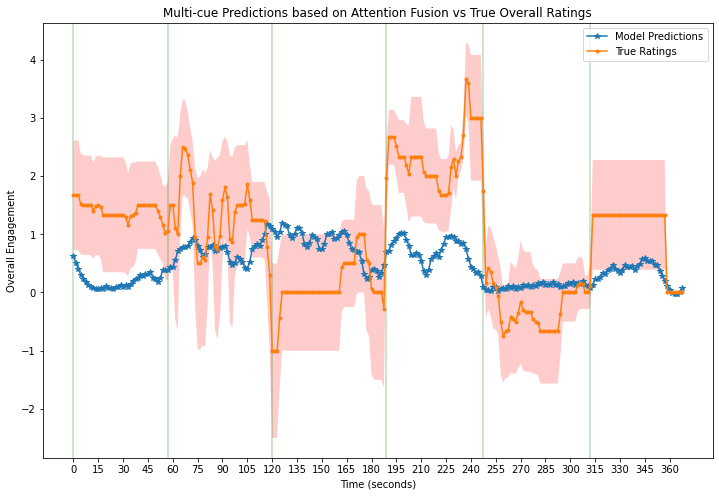

torch.Size([6])
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
tensor([0.1998, 0.1649, 0.4267, 0.7792, 0.6160, 1.0372, 0.9276, 0.7334, 0.6797,
        0.6048, 0.6931, 0.0694, 0.1319, 0.1340, 0.3666, 0.4324, 0.0091],
       device='cuda:0')

torch.Size([17])
torch.Size([17])


17


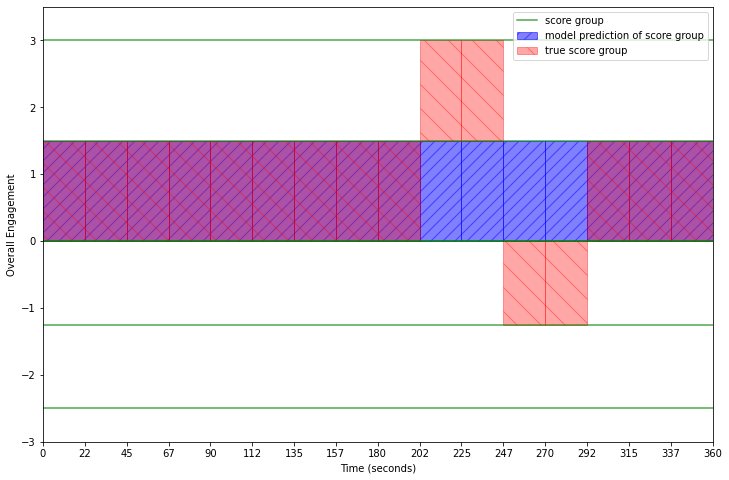

In [ ]:
single_cue_networks = ("BGRU_Att_face_align_seq_of_9", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

test_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=6,
                                          shuffle=False)

model_name = "BGRU_model_fusion_out_6_correct"
eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 6,
                single_cue_nets=single_cue_networks,
                smoothen=True, att=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
torch.Size([1, 6])
5.647236585617065
here
torch.Size([198])
torch.Size([198])
here
[0, 0]
CCC scores for BGRU_model_fusion_out_6_correct_fine_tuned_slow fusion on test set 
  on each video: [nan]
w_MSE scores for BGRU_model_fusion_out_6_correct_fine_tuned_slow fusion on test set 
  on each video: [nan]

Weigthed score for BGRU_model_fusion_out_6_correct_fine_tuned_slow for fusion with atte

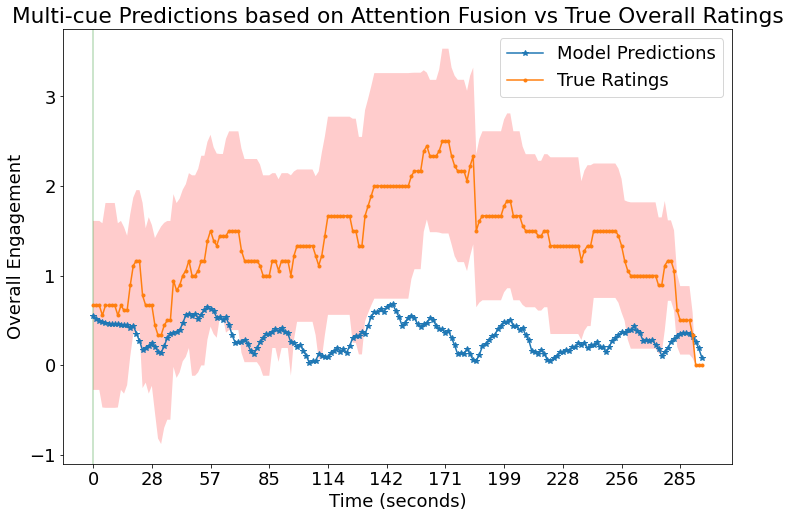

torch.Size([3])
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
tensor([0.4603, 0.2694, 0.5590, 0.2753, 0.2038, 0.2310, 0.5734, 0.3737, 0.2571,
        0.2482, 0.1946, 0.3119, 0.2677, 0.1777], device='cuda:0')

torch.Size([14])
torch.Size([14])


14


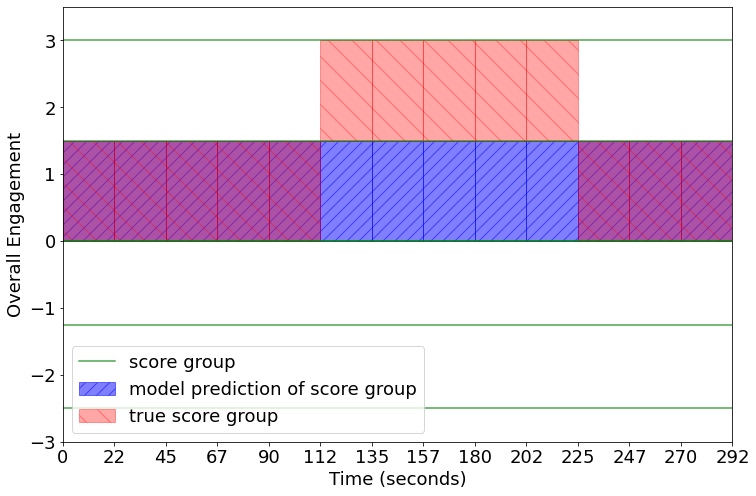

In [ ]:
# using different face single-cue network
single_cue_networks = ("BGRU_Att_face_align_seq_of_9_old", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

model_name = "BGRU_model_fusion_out_6_correct_fine_tuned_slow"
eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 6,
                single_cue_nets=single_cue_networks,
                smoothen=True, att=False)

### Fine-tuning Experiment
Below is an attempt to load in the already-trained model on batch 1 data above, and further fine-tune it on a snippet of data from batch 2, we then evaluate this on remaining batch 2 data. The outputs have been removed as this experiment proved inconclusive.

In [ ]:
va_padding = 1
VA=True
seq_len=9
batch_size=32

train_dataset = MultiModalDataset("train_3",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)


learning_rate = 0.000005
model_name = "BGRU_model_fusion_out_6_correct_fine_tuned_slow_try_2"
model_type = "GRU"
num_epochs = 100
out_dim = 6

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = torch.load(f"{content_path}/models/BGRU_model_fusion_out_6_correct")

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

single_cue_networks = ("BGRU_Att_face_align_seq_of_9", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

train_model_fusion(model, model_name, train_loader, None, 
                  criterion= "CCC",
                  optimiser = optimiser, 
                  single_cue_nets=single_cue_networks,
                  device=device, 
                  num_epochs = num_epochs,
                  seq_len = 6, out_seq = out_dim)

In [ ]:
test_dataset = MultiModalDataset("eval_video_1_whole",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=6,
                                          shuffle=False)

eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 6,
                single_cue_nets=single_cue_networks,
                smoothen=True, att=False)

# MLP Attention

## Training


load from dataframe - raw frames
torch.Size([5052])
torch.Size([5052])
torch.Size([5052, 1, 70, 3])
torch.Size([562, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([562, 9, 1, 70, 3])
torch.Size([562])

load from dataframe - raw frames
torch.Size([5052])
torch.Size([5052])
torch.Size([5052, 1, 67, 3])
torch.Size([562, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([562, 9, 1, 67, 3])
torch.Size([562])
1192

here - number of audio sequences
830

load from dataframe - raw frames
torch.Size([1443])
torch.Size([1443])
torch.Size([1443, 1, 70, 3])
torch.Size([161, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([161, 9, 1, 70, 3])
torch.Size([161])

load from dataframe - raw frames
torch.Size([1443])
torch.Size([1443])
torch.Size([1443, 1, 67, 3])
torch.Size([161, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([161, 9, 1, 67, 3])
torch.Size([161])
1192

here - number of audio sequences
239

load from dataframe - raw frames
torch.Si

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 0, Iteration: 0, training loss = 0.9952
Epoch: 1, Iteration: 0, training loss = 0.9887
Epoch: 2, Iteration: 0, training loss = 0.9902
Epoch: 3, Iteration: 0, training loss = 0.9920
Epoch: 4, Iteration: 0, training loss = 0.9798
Epoch: 5, Iteration: 0, training loss = 0.9953
Epoch: 6, Iteration: 0, training loss = 0.9924
Epoch: 7, Iteration: 0, training loss = 0.9726
Epoch: 8, Iteration: 0, training loss = 1.0016
Epoch: 9, Iteration: 0, training loss = 0.9758


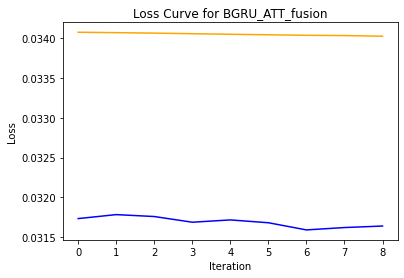

here
torch.Size([81])
torch.Size([81])

Weigthed score for BGRU_ATT_fusion for fusion with attention after smoothening: 0.5648121700738217
CCC score for BGRU_ATT_fusion for fusion with attention on test set: 0.020253184749344358


MSE error for BGRU_ATT_fusion on test set: 177.6921844482422
weighted MSE error for BGRU_ATT_fusion on test set: 138.426950552825
81
81


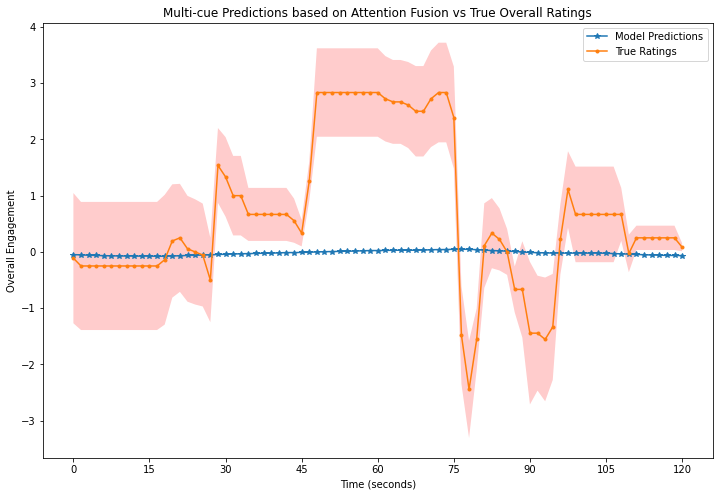

torch.Size([6])
[3, 3, 4, 4, 3, 3]
tensor([-0.0682, -0.0356,  0.0143,  0.0306, -0.0242, -0.0590], device='cuda:0')

torch.Size([6])
torch.Size([6])


6


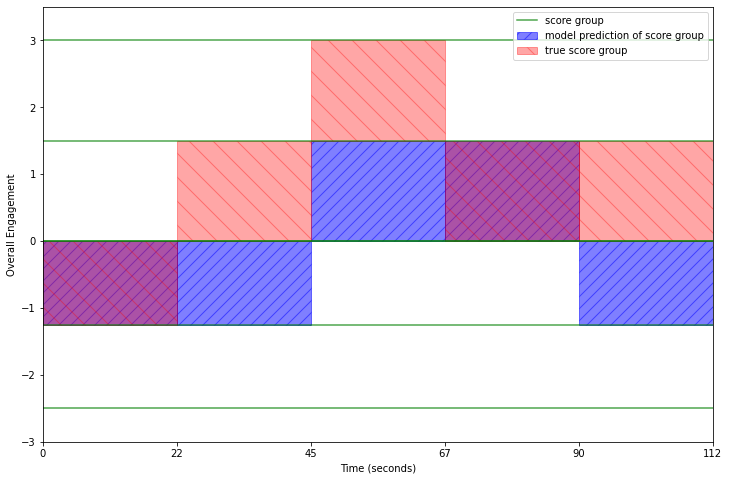

In [ ]:
# Dataset Hparams
va_padding = 1
VA=True
seq_len=9
batch_size=32

# Train on batch 1
video_label_path=f'{content_path}/video_features/opinions_visual.csv'
video_path=f'{content_path}/video_features/video_b1_'

audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
audio_path = f"{content_path}/dataset/audio/"

train_dataset = MultiModalDataset("training",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

valid_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_dataset = MultiModalDataset("test",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

hidden_dim = 128
layer_dim = 5
learning_rate = 0.00001
model_name = "BGRU_ATT_fusion"
model_type = "GRU"
num_epochs = 100
valid_freq = 1
patience = 5
bidir=True

single_cue_networks = ("BGRU_Att_face_align_seq_of_9_copy", 
                       "GRU_Att_body2_aligned_seq_9_copy",
                       "GRU_voice_va_short_seq_copy") 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_fusion_with_att(model_name, train_loader, valid_loader,criterion= "CCC",
                      single_cue_nets=single_cue_networks,
                      device=device, learning_rate=learning_rate, valid_freq=valid_freq,
                      patience_threshold=patience, out_seq=1)

eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True)

## Evaluation


load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 70, 3])
torch.Size([242, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([242, 9, 1, 70, 3])
torch.Size([242])

load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 67, 3])
torch.Size([242, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([242, 9, 1, 67, 3])
torch.Size([242])
1215

here - number of audio sequences
242
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Si

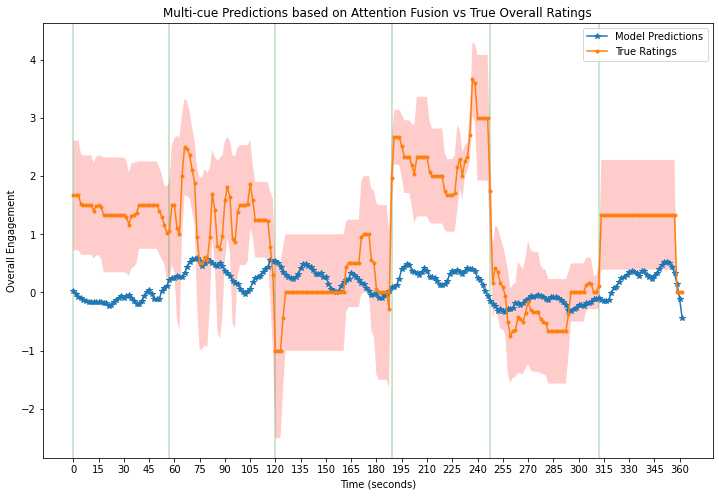

torch.Size([2])
[3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3]
tensor([-0.1352, -0.1129,  0.1166,  0.5154,  0.1727,  0.3826,  0.2952,  0.1493,
         0.1632,  0.2672,  0.2860, -0.2365, -0.0894, -0.2010,  0.1620,  0.3675,
        -0.2683], device='cuda:0')

torch.Size([17])
torch.Size([17])


17


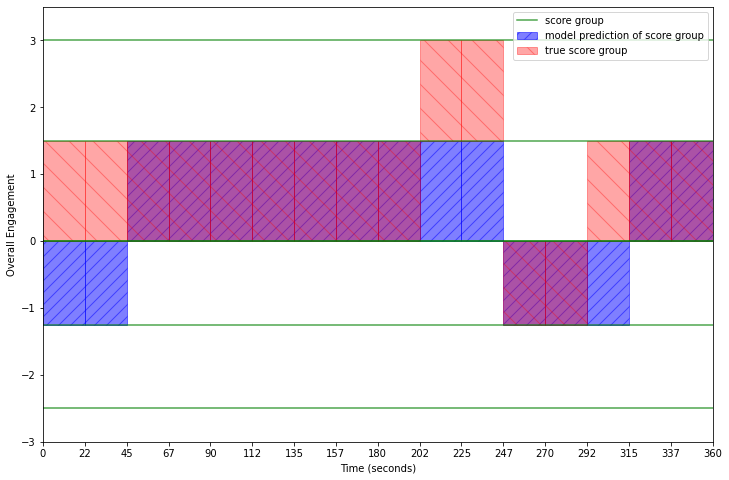

In [ ]:
video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

test_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

single_cue_networks=("BGRU_Att_face_align_seq_of_9", 
                     "GRU_Att_body_aligned_seq_9" ,
                     "GRU_voice_va_short_seq")

eval_fusion_att(seq_len=9, network_name="BGRU_ATT_fusion_with_seq_2fcs_att_1out",
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True)


load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])

load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 67, 3])
torch.Size([120, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([120, 9, 1, 67, 3])
torch.Size([120])
1192

here - number of audio sequences
122
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Si

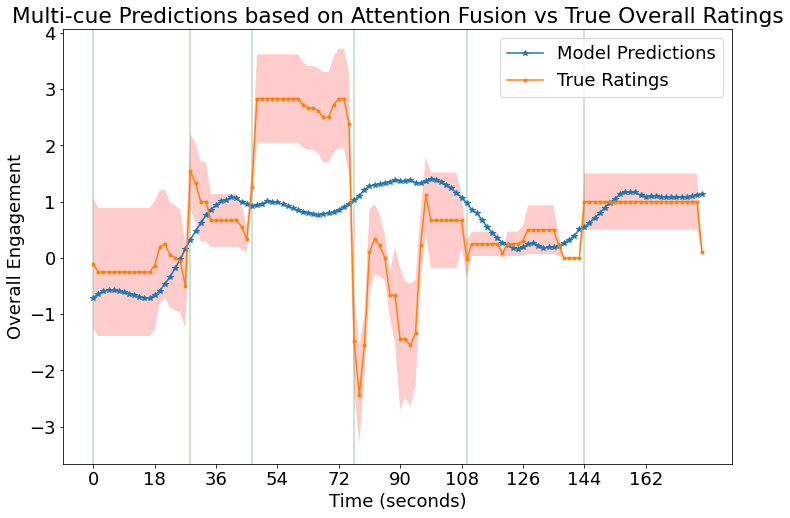

torch.Size([0])
[3, 4, 4, 4, 4, 4, 4, 4]
tensor([-0.6270,  0.5840,  0.9009,  1.0947,  1.2603,  0.3295,  0.6545,  1.1050],
       device='cuda:0')

torch.Size([8])
torch.Size([8])


8


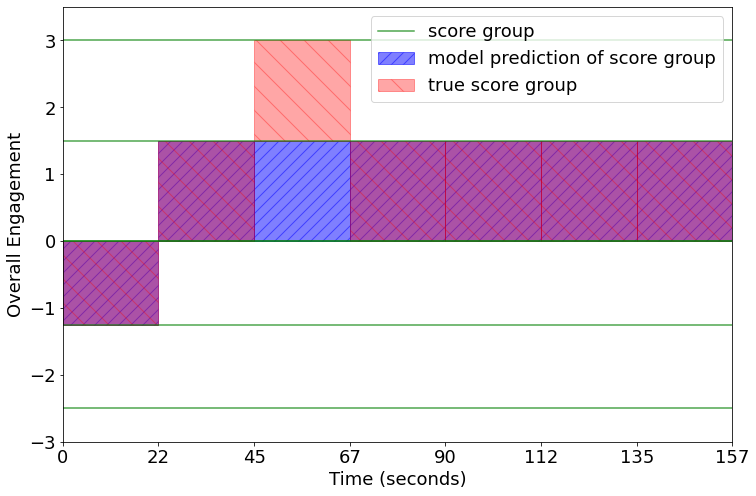

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')
execfile(f'{content_path}/API/fusion.py')

video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

# video_label_path=f'{content_path}/video_features/opinions_visual.csv'
# video_path=f'{content_path}/video_features/video_b1_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

# audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
# audio_path = f"{content_path}/dataset/audio/"

test_dataset = MultiModalDataset("test",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

single_cue_networks=("BGRU_Att_face_align_seq_of_9", 
                     "GRU_Att_body_aligned_seq_9" ,
                     "GRU_voice_va_short_seq")

eval_fusion_att(seq_len=9, network_name="BGRU_ATT_fusion_with_seq_2fcs_att_1out",
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True)


load from dataframe - raw frames
torch.Size([1950])
torch.Size([1950])
torch.Size([1950, 1, 70, 3])
torch.Size([217, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([217, 9, 1, 70, 3])
torch.Size([217])

load from dataframe - raw frames
torch.Size([1950])
torch.Size([1950])
torch.Size([1950, 1, 67, 3])
torch.Size([217, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([217, 9, 1, 67, 3])
torch.Size([217])
1215

here - number of audio sequences
218
12.020604610443115
here
torch.Size([217])
torch.Size([217])
here
[0, 0]
CCC scores for BGRU_ATT_fusion_with_seq_2fcs_att_1out fusion on test set 
  on each video: [nan]
w_MSE scores for BGRU_ATT_fusion_with_seq_2fcs_att_1out fusion on test set 
  on each video: [nan]

Weigthed score for BGRU_ATT_fusion_with_seq_2fcs_att_1out for fusion with attention after smoothening: 0.6437916890594539
CCC score for BGRU_ATT_fusion_with_seq_2fcs_att_1out for fusion with attention on test set: -0.003141628609458524


MSE error for 

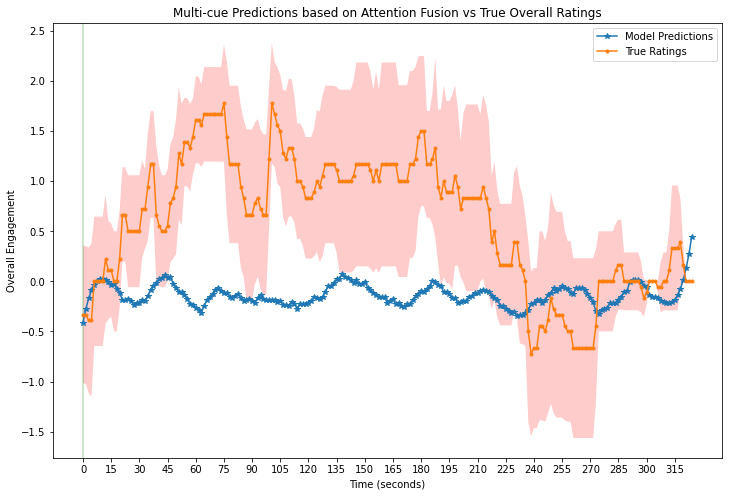

torch.Size([7])
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4]
tensor([-0.0914, -0.1191, -0.1529, -0.1390, -0.1960, -0.1639, -0.0171, -0.1953,
        -0.1009, -0.1528, -0.2699, -0.0901, -0.2018, -0.1156,  0.0666],
       device='cuda:0')

torch.Size([15])
torch.Size([15])


15


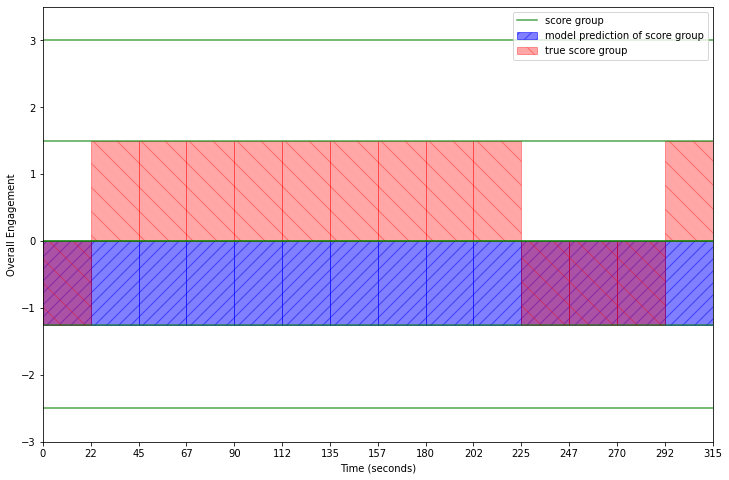

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')
execfile(f'{content_path}/API/fusion.py')

video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

# video_label_path=f'{content_path}/video_features/opinions_visual.csv'
# video_path=f'{content_path}/video_features/video_b1_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

# audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
# audio_path = f"{content_path}/dataset/audio/"

test_dataset = MultiModalDataset("eval_video_5_whole",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

single_cue_networks=("BGRU_Att_face_align_seq_of_9", 
                     "GRU_Att_body_aligned_seq_9" ,
                     "GRU_voice_va_short_seq")

eval_fusion_att(seq_len=9, network_name="BGRU_ATT_fusion_with_seq_2fcs_att_1out",
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True)

In [ ]:
train_dataset = MultiModalDataset("training",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

valid_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)


load from dataframe - raw frames
torch.Size([701])
torch.Size([701])
torch.Size([701, 1, 70, 3])
torch.Size([78, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([78, 9, 1, 70, 3])
torch.Size([78])

load from dataframe - raw frames
torch.Size([701])
torch.Size([701])
torch.Size([701, 1, 67, 3])
torch.Size([78, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([78, 9, 1, 67, 3])
torch.Size([78])
1215

here - number of audio sequences
123
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([14, 1])
here
torch.Size([78])
torch.Size([78])

Weigthed score for BGRU_ATT_fusion_with_seq_2fcs_att_1out for fusion with attention after smoothening: 0.5240892463229206
CCC score for BGRU_ATT_fusion_with_seq_2fcs_att_1out for fusion with attention on test set: -0.014706923023109417


MSE error for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 175.1823272705078
weighted MSE error for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 127.2211440095593
78
78


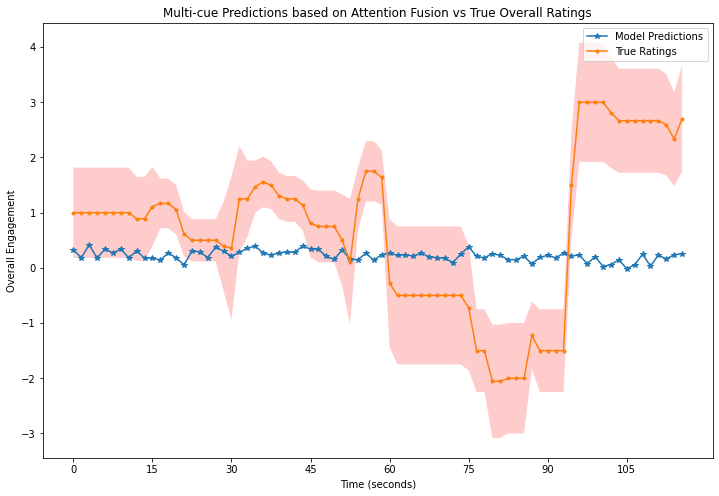

torch.Size([3])
[4, 4, 4, 4, 4, 4]
tensor([0.2368, 0.2957, 0.2351, 0.1958, 0.1456, 0.2185], device='cuda:0')

torch.Size([6])
torch.Size([6])


6


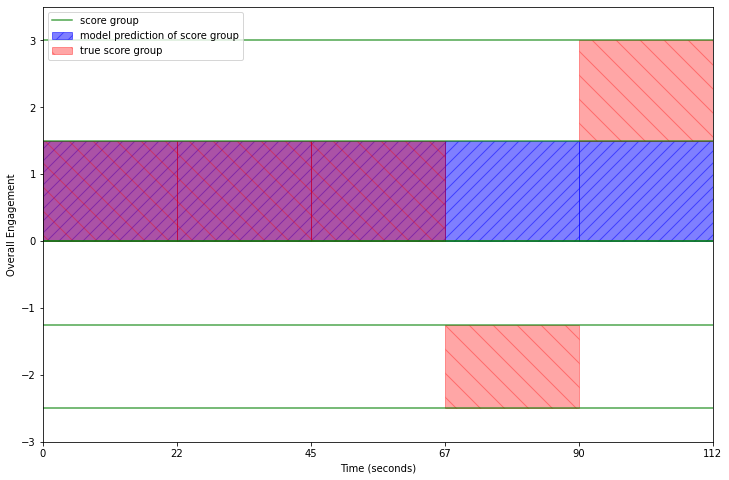

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')
execfile(f'{content_path}/API/fusion.py')

seq_len=9
batch_size=32
video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

dataset="test"


test_dataset = MultiModalDataset("test",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

single_cue_networks = ("BGRU_Att_face_align_seq_of_9", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_spectrogram") 

eval_fusion_att(seq_len=9, network_name="BGRU_ATT_fusion_with_seq_2fcs_att_1out",
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = False)

faces: torch.Size([120, 9, 1, 70, 3])
poses: torch.Size([120, 9, 1, 67, 3])
voices: 115
4.7161664962768555
here
torch.Size([115])
torch.Size([115])
no vid segmentation

Weigthed score for BGRU_ATT_fusion_with_seq_2fcs_att_1out for fusion with attention after smoothening: 0.6158379912376404
CCC score for BGRU_ATT_fusion_with_seq_2fcs_att_1out for fusion with attention on test set: 0.41484183073043823


MSE error for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 49.36152648925781
weighted MSE error for BGRU_ATT_fusion_with_seq_2fcs_att_1out on test set: 65.43115234375
115
115


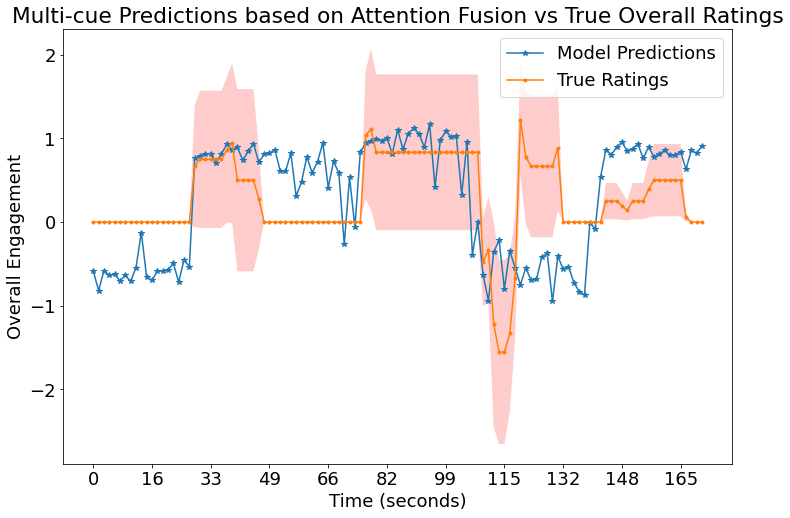

torch.Size([10])
[3, 4, 4, 4, 4, 3, 4, 4]
tensor([-0.6055,  0.4513,  0.6952,  0.7385,  0.5389, -0.5468,  0.3900,  0.8106],
       device='cuda:0')

torch.Size([8])
torch.Size([8])


8


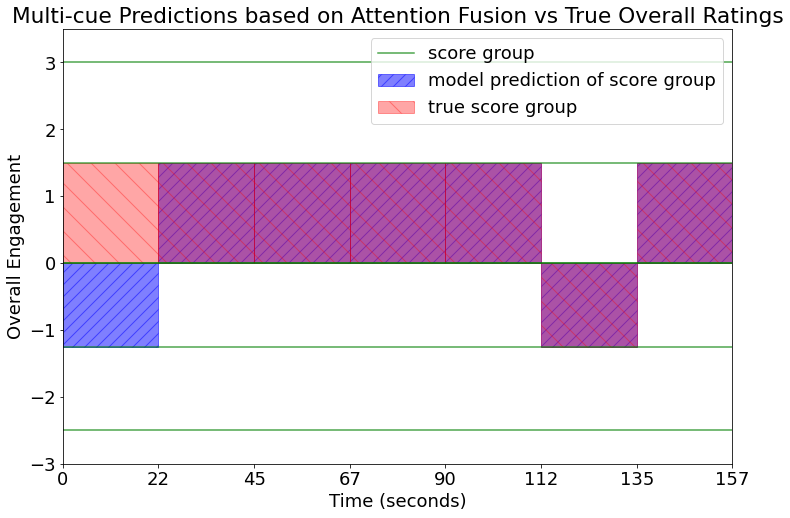

In [ ]:
execfile(f'{content_path}/API/helpers.py')
execfile(f'{content_path}/API/RNN.py')
execfile(f'{content_path}/API/fusion.py')
import time
test_dataset = AttentionPredictionDataset("test",  frames_per_seq=9, device=device)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)
single_cue_networks = ("BGRU_Att_face_align_seq_of_9_old", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

eval_fusion_att(seq_len=9, network_name="BGRU_ATT_fusion_with_seq_2fcs_att_1out",
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = False)

# Dot Attention 


## Training


load from dataframe - raw frames
torch.Size([7492])
torch.Size([7492])
torch.Size([7492, 1, 70, 3])
torch.Size([833, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([833, 9, 1, 70, 3])
torch.Size([833])

load from dataframe - raw frames
torch.Size([7492])
torch.Size([7492])
torch.Size([7492, 1, 67, 3])
torch.Size([833, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([833, 9, 1, 67, 3])
torch.Size([833])
1192

here - number of audio sequences
830

load from dataframe - raw frames
torch.Size([2140])
torch.Size([2140])
torch.Size([2140, 1, 70, 3])
torch.Size([238, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([238, 9, 1, 70, 3])
torch.Size([238])

load from dataframe - raw frames
torch.Size([2140])
torch.Size([2140])
torch.Size([2140, 1, 67, 3])
torch.Size([238, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([238, 9, 1, 67, 3])
torch.Size([238])
1192

here - number of audio sequences
239
cuda
Epoch: 0, Iteration: 0, training loss

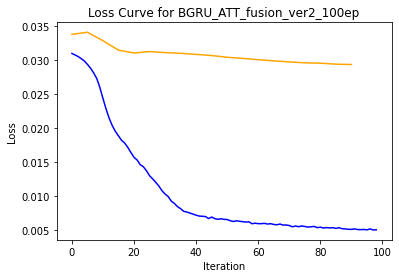

In [ ]:
va_padding = 1
VA=True
seq_len=9
batch_size=32

video_label_path=f'{content_path}/video_features/opinions_visual.csv'
video_path=f'{content_path}/video_features/video_b1_'

audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
audio_path = f"{content_path}/dataset/audio/"

train_dataset = MultiModalDataset("training",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

valid_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

hidden_dim = 128
layer_dim = 2
learning_rate = 0.000005
model_name = "BGRU_ATT_fusion_ver2_100ep"
model_type = "GRU"
num_epochs = 100
valid_freq = 5
patience = 5
bidir=True

single_cue_networks = ("BGRU_Att_face_align_seq_of_9_old", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_fusion_with_att(model_name, train_loader, valid_loader,criterion= "CCC",
                      single_cue_nets=single_cue_networks,
                      device=device, learning_rate=learning_rate, valid_freq=valid_freq,
                      patience_threshold=patience, out_seq=1,
                      num_epochs=num_epochs, hidden_dim=hidden_dim,
                      att_ver=2)

## Evaluation

We evaluate on batch 2 data, using the entirety of video 1, the 30 second test splits and the 45 second validation splits from this unseen dataset.


load from dataframe - raw frames
torch.Size([1752])
torch.Size([1752])
torch.Size([1752, 1, 70, 3])
torch.Size([195, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([195, 9, 1, 70, 3])
torch.Size([195])

load from dataframe - raw frames
torch.Size([1752])
torch.Size([1752])
torch.Size([1752, 1, 67, 3])
torch.Size([195, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([195, 9, 1, 67, 3])
torch.Size([195])
1215

here - number of audio sequences
196
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([3, 1])
6.138143301010132
here
torch.Size([195])
torch.Size([195])
here
[0, 0]
CCC scores for BGRU_ATT_fusion_ver2_100ep fusion on test set 
  on each video: [nan]
w_MSE scores for BGRU_ATT_fusion_ver2_100ep fusion on test set 
  on each video: [nan]

Weigthed score for BGRU_ATT_fusion_ver2_100ep for fusion with attention after smoothening: 0.7671790051511967
CCC score for BGRU_ATT_fusio

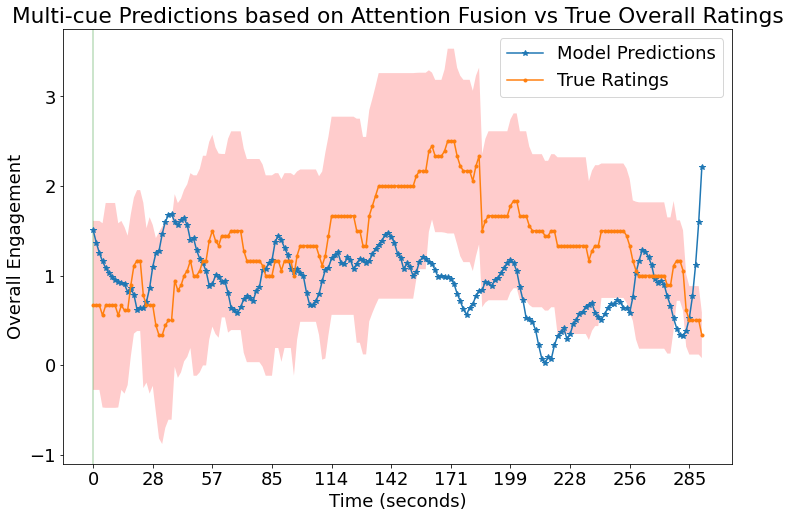

torch.Size([0])
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
tensor([1.0107, 1.2869, 1.0734, 0.9185, 0.9877, 1.1677, 1.2459, 0.9488, 0.9322,
        0.3960, 0.5348, 0.8964, 0.8258], device='cuda:0')

torch.Size([13])
torch.Size([13])


13


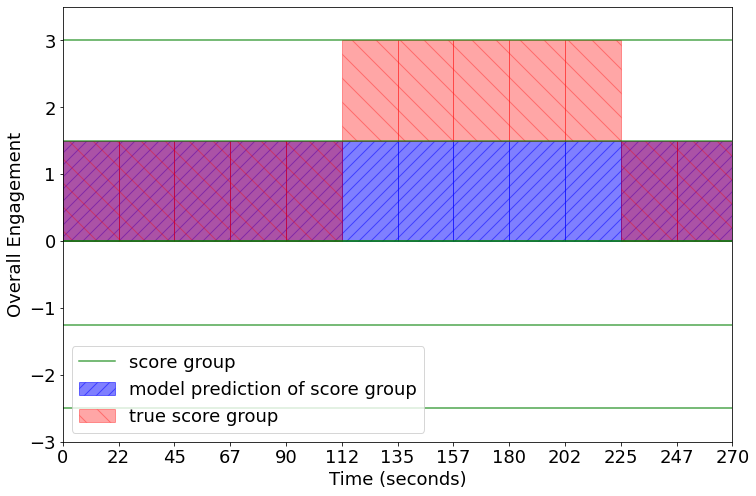

In [ ]:
seq_len=9
batch_size=32

model_name = "BGRU_ATT_fusion_ver2_100ep"


single_cue_networks = ("BGRU_Att_face_align_seq_of_9_old", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

test_dataset = MultiModalDataset("eval_video_1_whole",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True,
                att=True)


load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 70, 3])
torch.Size([120, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([120, 9, 1, 70, 3])
torch.Size([120])

load from dataframe - raw frames
torch.Size([1072])
torch.Size([1072])
torch.Size([1072, 1, 67, 3])
torch.Size([120, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([120, 9, 1, 67, 3])
torch.Size([120])
1192

here - number of audio sequences
122
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([24, 1])
2.2521095275878906
here
torch.Size([120])
torch.Size([120])
here
[0, 172, 284, 461, 659, 864, 1072]
CCC scores for BGRU_ATT_fusion_ver2_100ep fusion on test set 
  on each video: [-0.009152534063273755, -0.016412197872198785, -0.12861978254858902, -0.10512523705519045, 0.06698531089042559, 0.0]
w_MSE scores for BGRU_ATT_fusion_ver2_100ep fusion on test set 
  on each video: [0.8967231056172238, -0.07150421582060895, 0.7475565453848636, 0

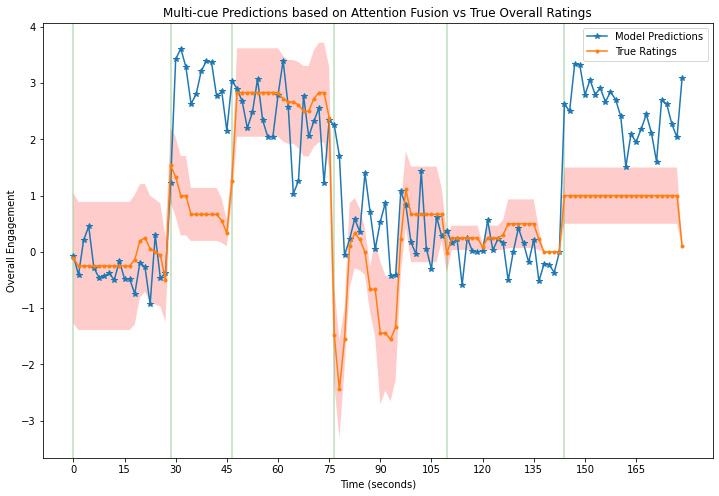

torch.Size([0])
[3, 5, 5, 4, 4, 4, 5, 5]
tensor([-0.2794,  2.0735,  2.4018,  1.3667,  0.3482,  0.0532,  1.6600,  2.3066],
       device='cuda:0')

torch.Size([8])
torch.Size([8])


8


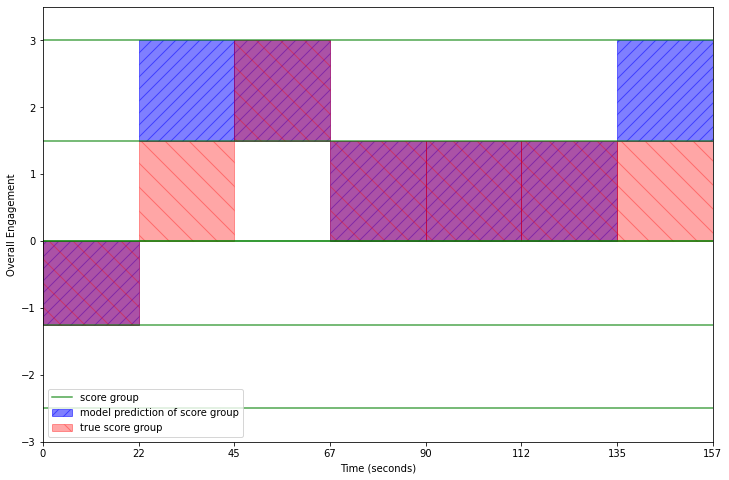

In [ ]:
seq_len=9
batch_size=32

model_name = "BGRU_ATT_fusion_ver2_100ep"


single_cue_networks = ("BGRU_Att_face_align_seq_of_9_old", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

video_label_path=f'{content_path}/video_features/opinions_visual.csv'
video_path=f'{content_path}/video_features/video_b1_'

audio_label_path = f"{content_path}/dataset/audio/opinions_audio.csv"
audio_path = f"{content_path}/dataset/audio/"

test_dataset = MultiModalDataset("test",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True,
                att = True)


load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 70, 3])
torch.Size([242, 9, 1, 70, 3])

here - number of sequences for face
torch.Size([242, 9, 1, 70, 3])
torch.Size([242])

load from dataframe - raw frames
torch.Size([2169])
torch.Size([2169])
torch.Size([2169, 1, 67, 3])
torch.Size([242, 9, 1, 67, 3])

here - number of sequences for pose
torch.Size([242, 9, 1, 67, 3])
torch.Size([242])
1215

here - number of audio sequences
242
6.261855125427246
here
torch.Size([241])
torch.Size([241])
here
[0, 350, 720, 1136, 1490, 1880, 2169]
CCC scores for BGRU_ATT_fusion_ver2_100ep fusion on test set 
    on each video: [-0.011230565673184605, -0.08498022155264867, -0.011465497307235244, 0.07765352781368634, -0.013714241088113114, 0.2172912696279036]
w_MSE scores for BGRU_ATT_fusion_ver2_100ep fusion on test set 
    on each video: [0.6576766360567519, 0.8467203263314864, 0.4990247259232252, 0.6615121122757999, 0.3989245890706906, 0.7411519612064474]



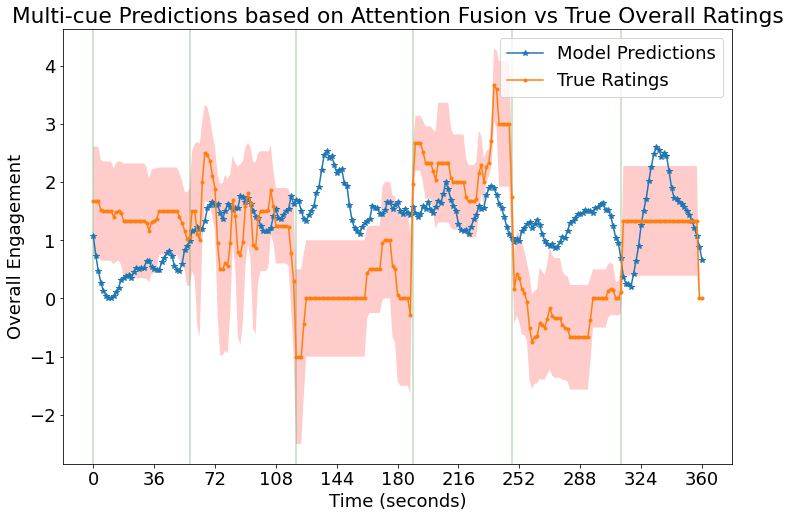

torch.Size([1])
[4, 4, 4, 5, 4, 5, 5, 4, 5, 4, 5, 4, 4, 4, 4, 5, 4]
tensor([0.3060, 0.5534, 0.9123, 1.5787, 1.3960, 1.5786, 2.0122, 1.4585, 1.5144,
        1.4977, 1.5777, 1.1417, 1.1802, 1.3078, 1.4316, 1.6507, 0.6636],
       device='cuda:0')

torch.Size([17])
torch.Size([17])



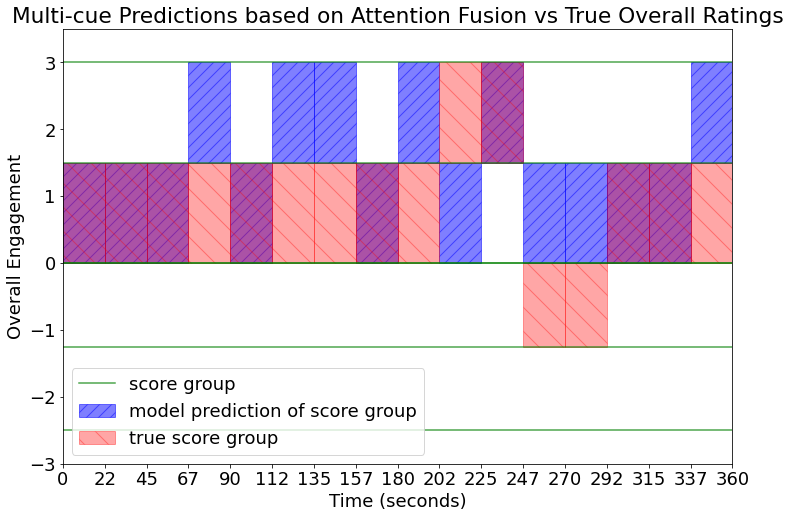

In [ ]:
seq_len=9
batch_size=32
import time

model_name = "BGRU_ATT_fusion_ver2_100ep"


single_cue_networks = ("BGRU_Att_face_align_seq_of_9_old", 
                       "GRU_Att_body2_aligned_seq_9",
                       "GRU_voice_va_short_seq") 

video_label_path=f'{content_path}/test_pipeline/opinions_visual.csv'
video_path=f'{content_path}/test_pipeline/videos_eval/video_b2_'

audio_label_path = f"{content_path}/test_pipeline/opinions_audio.csv"
audio_path = f"{content_path}/test_pipeline/videos_eval/dataset/dataset_audio_segments"

test_dataset = MultiModalDataset("validation",  audio_path, audio_label_path,
                                 video_path, video_label_path,
                                 frames_per_seq=seq_len, device=device)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

eval_fusion_att(seq_len=9, network_name=model_name,
                test_loader = test_loader,
                out_len = 1,
                single_cue_nets=single_cue_networks,
                smoothen = True,
                att = True)

# Online Processing 

In [ ]:
def online_processing(section = True):
  seq_len = 9
  NA = -100.

  path_f = f'{content_path}/models/{f}'
  path_p = f'{content_path}/models/{p}'
  path_v = f'{content_path}/models/{v}'

  scorer_f=torch.load(path_f)
  scorer_p=torch.load(path_p)
  scorer_v=torch.load(path_v)

  scorer_f.eval().to(device)
  scorer_p.eval().to(device)
  scorer_v.eval().to(device)

  network = torch.load(f'{content_path}/models/{network_name}')
  network.eval()

  vidcap=cv2.VideoCapture(video_path)
  audio = AudioSegment.from_mp3(audio_path)

  # get frame rate of video
  fps = round(vidcap.get(5))
  print(f"Video has {fps} fps")
  skip_rate = round(fps/6)

  if section:
    # skip to begin of sequence
    start_frame = 60 * fps
    # start_frame = 0
    end_frame = 180 * fps
    # 10 seconds of frames
    # end_frame = start_frame + 210 * fps
    print(f'Printing {(end_frame - start_frame)/6} frames')

  # create a folder to save Images if folder not existed
  path = f'{content_path}/test_pipeline/{name}/frames/'
  if not os.path.exists(path):
      os.makedirs(path)

  count = 0

  while(vidcap.isOpened() and count<start_frame):
    ret, frame = vidcap.read()
    if (ret != True):
        break
    count +=1 
  
  while(vidcap.isOpened() and count<end_frame and ret==True):
    ################
    # feature extraction
    ################

    features_face_vec = torch.full((seq_len, 1, 70, 3), NA).cuda()
    features_body_vec = torch.full((seq_len, 1, 25, 3), NA).cuda()
    features_hand_vec = torch.full((seq_len, 2, 21, 3), NA).cuda()
    features_pose_vec = torch.full((seq_len, 1, 67, 3), NA).cuda()

    for j in range(seq_len):
      frameId = vidcap.get(1) #current frame number
      while (count % skip_rate != 0):
        ret, frame = vidcap.read()
        if (ret != True):
            break
        count += 1
      ret, frame = vidcap.read()
      if (ret != True):
          break

      count += 1

      datum.cvInputData = frame
      opWrapper.emplaceAndPop(op.VectorDatum([datum]))

      if(datum.poseKeypoints is None): 
        continue

      # per frame
      body = torch.tensor(np.array(datum.poseKeypoints), dtype=torch.float16)
      hand = torch.tensor(np.array(datum.handKeypoints), dtype=torch.float16)
      face = torch.tensor(np.array(datum.faceKeypoints), dtype=torch.float16)
      
      if (body.shape[0] > 1):
        areas = [Polygon(person).area for person in body]
        speaker = np.argmax(np.array(areas))

        body = body[speaker].reshape(1, body.shape[1], body.shape[2])
        face = face[speaker].reshape(1, face.shape[1], face.shape[2])
        hand = hand[:, speaker, :, :]

      hand = hand.squeeze(1)

      if not torch.all(face) == 0:
        features_face[j] = face

      if not torch.all(hand) == 0:  
        features_hand[j] = hand
      
      features_body[j] = body

      # if extract_boxes and (i % 10 == 0):
      #   img = input_image
      #   for p in [face[0], hand[0], hand[1], body[0]]:
      #     points = p[p.sum(dim=1) != 0]

      #     points = np.float32(points[:,:2].detach())
      #     box = np.int0(cv2.boxPoints(cv2.minAreaRect(points)))
      #     img = cv2.drawContours(img, [box], 0, (255, 0, 0), 2)

      #   cv2.imwrite(f'{path}/extracted/{filename}.png', img)

    features_hand = features_hand.reshape(features_hand.shape[0], 1, 42, 3)
    features_pose = torch.cat([features_body, features_hand], axis=2)

    #######
    # align
    #######

    features_pose = align_crop_resize_per_seq("pose", data=features_pose)
    features_face = align_crop_resize_per_seq("face", data=features_face)

    ###########
    # audio
    ############

    newAudio = audio[count:count+3000]
    print(count)

    features_voice = librosa.feature.mfcc(y=clip[1].astype(float), sr=clip[0], 
                                    hop_length=512, n_fft=2048).transpose().astype(np.float32)
    features_voice = torch.tensor(features_voice)

    ####
    # models
    #####

    with torch.no_grad():
      if att:
        f, f_h = scorer_f(features[0].to(device), att)
        p, _= scorer_p(features[1].to(device), att) 
        v, _= scorer_v(features[2].to(device), att)

        network_prediction = network(f,p,v)

      else:  
        # print(features[0].shape)
        
        f = scorer_f(features[0].to(device), att)
        p = scorer_p(features[1].to(device), att) 
        v = scorer_v(features[2].to(device), att)
        
        # print(f.shape)

        f = create_seq_scores(f.flatten(), 6) 
        p = create_seq_scores(p.flatten(), 6) 
        v = create_seq_scores(v.flatten(), 6) 
        # print(f.shape)

        input = torch.stack([f, p, v], dim=-1)
        # print(input.shape)
      
        network_prediction = network(input.to(device))
    outs.append(network_prediction.squeeze(0))

  outs= torch.stack(outs)

  plt.title(f"Multi-cue Predictions based on Attention Fusion vs True Overall Ratings")
  print(len(outs))

  plt.plot(range(outs.shape[0]), outs.cpu(), label = 'Model Predictions', marker='*')

  # seq_len of 1.5 sec for now
  plt.xticks(range(0, int(len(outs)), 10), [int(i * 1.5) for i in range(0, len(outs), 10)])

  plt.xlabel('Time (seconds)')
  plt.ylabel('Overall Engagement')

  plt.legend()
  plt.show() 

  vidcap.release()
  print(f"Done! Extracted {len(os.listdir(path))} frames")
  print()
  cv2.destroyAllWindows()